<a href="https://colab.research.google.com/github/mlaugharn/math189covid19/blob/master/covid_second_wave_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tcn

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=433ddcba9b794a8aea067f69b4fc7c681efb9f035d813276e573fa2b433a5c0e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [2]:
# data sources
# apple maps movement trends
# google maps movement trends
# global policies dataset
# all per state
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
import pprint
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

# Data acquisition

In [3]:
USA = {'Mississippi', 'Virginia', 'South Carolina', 'Massachusetts', 'New Jersey', 'Arkansas', 'Tennessee', 'Hawaii', 'South Dakota', 'Alaska', 'North Dakota', 'Kansas', 'Utah', 'Texas', 'Louisiana', 'District of Columbia', 'Wyoming', 'Oklahoma', 'Pennsylvania', 'Kentucky', 'Connecticut', 'New York', 'Montana', 'Vermont', 'West Virginia', 'Maine', 'Maryland', 'Missouri', 'New Mexico', 'Ohio', 'Illinois', 'Minnesota', 'New Hampshire', 'Oregon', 'Washington', 'Delaware', 'Michigan', 'California', 'Idaho', 'Georgia', 'Nebraska', 'Arizona', 'Florida', 'Alabama', 'North Carolina', 'Colorado', 'Indiana', 'Iowa', 'Wisconsin', 'Nevada', 'Rhode Island'}
downloaded_datasets = {}
def get_apple_data(date = None):
    # focus on driving data
    if 'apple' in downloaded_datasets: return downloaded_datasets['apple']
    if date == None: 
        output = {}
        apple_covid_df = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2008HotfixDev26/v2/en-us/applemobilitytrends-2020-05-13.csv")
        apple_covid_df['region'] = apple_covid_df['region'].replace({'Washington DC': 'District of Columbia'})
        # filter to US regions
        #apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']].reset_index()
        #print(apple_covid_df.index[apple_covid_df['region'].isin(USA)])
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['region'].isin(USA)]]
        #apple_covid_df = apple_covid_df.drop(columns='geo_type')
        # filter to only driving data
        # dataset currently has 1 date as 1 column
        # now need to make 1 date = 1 row
        apple_covid_df = apple_covid_df.melt(id_vars=['geo_type', 'region', 'alternative_name', 'transportation_type'], var_name='date', value_name='driving_percent')
        apple_covid_df['date'] = pd.to_datetime(apple_covid_df['date'], errors='coerce')
        # apparently may 11th and may 12th were blank so only use data before then
        apple_covid_df = apple_covid_df[apple_covid_df['date'] < pd.to_datetime('May 11th 2020')]
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']]
        apple_covid_df['driving_percent'] = (apple_covid_df['driving_percent'].astype(float) - 100) * (1/100.)
        for region, region_df in apple_covid_df.groupby('region'):
            output[region] = region_df
        print(output.keys())
        assert len(output) == 51, "Not 51 regions in Apple data"
        downloaded_datasets['apple'] = output
        return output
    else: assert False, "date specific data not implemented yet"

def get_google_data(date = None):
    if 'google' in downloaded_datasets: return downloaded_datasets['google']
    if date == None: 
        google_covid_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=722f3143b586a83f', dtype={'sub_region_2': str}, parse_dates=['date'], infer_datetime_format=True)
        states_google_covid_df = google_covid_df.iloc[google_covid_df.index[(google_covid_df['country_region_code'] == 'US') & (google_covid_df.sub_region_1.notnull()) & (google_covid_df.sub_region_2.isnull())]]
        cols_to_change = ["retail_and_recreation_percent_change_from_baseline",
                          "grocery_and_pharmacy_percent_change_from_baseline",
                          "parks_percent_change_from_baseline",
                          "transit_stations_percent_change_from_baseline",
                          "workplaces_percent_change_from_baseline",
                          "residential_percent_change_from_baseline"]
        for col_to_change in cols_to_change:
            states_google_covid_df[col_to_change] = states_google_covid_df[col_to_change].astype(float) * (1/100.)
        output = {}
        for region, region_df in states_google_covid_df.groupby('sub_region_1'):
            output[region] = region_df

        assert len(output) == 51, "Not 51 regions in Google data"
        downloaded_datasets['google'] = output
        return output
    else: assert False, "date specific data not implemented yet"

def get_covid_act_now_data(date = None):
    if 'covid_act_now' in downloaded_datasets: return downloaded_datasets['covid_act_now']
    if date == None: 
        act_now_df = pd.read_csv("https://data.covidactnow.org/latest/us/states.OBSERVED_INTERVENTION.timeseries.csv", parse_dates=['date', 'lastUpdatedDate'], infer_datetime_format=True)
        act_now_df['RtIndicator'] = act_now_df['RtIndicator'].fillna(method='bfill')
        act_now_df['RtIndicatorCI90'] = act_now_df['RtIndicatorCI90'].fillna(method='bfill')
        output = {}
        for region, region_df in act_now_df.groupby('stateName'): # split into state dfs
            non_future_data = region_df[region_df['date'] <= pd.to_datetime('now')] # remove rows that speculate about future hospital requirements etc.
            output[region] = non_future_data
        assert len(output) == 51, "Not 51 regions in Covid Act Now data" # states + dc
        downloaded_datasets['covid_act_now'] = output
        return output

def get_states_policies_data(date = None):
    '''Here's the methodology:

    0. No or few containment measures in place.

    1. Ban on public gatherings, cancellation of major events and conferences. 
     It’s not always easy to know when a country goes from step 0 to step 1.
     I’ve used public announcements by the government and looked at major
      sporting and cultural events in the country and when they became cancelled.

    2. Schools and universities closed. 
     As from the first day of closure, not when the announcement is made.
     Dates largely match those available from Unesco at the following web address: 
     https://en.unesco.org/themes/education-emergencies/coronavirus-school-closures

    3. Non-essential shops, restaurants and bars closed.
     As from the first day of closure, not when the announcement is made.

    4. Night curfew/Partial lockdown in place. 
    Applied for part of the day (usually at night) or for broad population categories (eg, people aged over 60).

    5. All-day lockdown. 
    Government requires citizens to shelter in place all day long.
     Citizens are allowed to come out to buy essential items.

    6. Harsh lockdown. 
    Citizens are not allowed to come out of their home, even to buy essential items.
    '''
    if 'policies' in downloaded_datasets: return downloaded_datasets['policies']
    if date == None:
        policies_df = pd.read_csv("https://raw.githubusercontent.com/OlivierLej/Coronavirus_CounterMeasures/master/dataset.csv")
        print(policies_df.head())
        us_policies_df = policies_df.iloc[policies_df.index[policies_df['country_name'] == 'United States']]
        us_policies_df = us_policies_df.drop(columns=['country_name'])
        us_policies_df.head()
        outputs = {}
        us_state_abbrev = {
            'AL': 'Alabama',
            'AK': 'Alaska',
            'AZ': 'Arizona',
            'AR': 'Arkansas',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'HI': 'Hawaii',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'IA': 'Iowa',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'ME': 'Maine',
            'MD': 'Maryland',
            'MA': 'Massachusetts',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MS': 'Mississippi',
            'MO': 'Missouri',
            'MT': 'Montana',
            'NE': 'Nebraska',
            'NV': 'Nevada',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NY': 'New York',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VT': 'Vermont',
            'VA': 'Virginia',
            'WA': 'Washington',
            'WV': 'West Virginia',
            'WI': 'Wisconsin',
            'WY': 'Wyoming',
        }
        us_policies_df['country_id'] = us_policies_df['country_id'].replace(us_state_abbrev)
        def renamed(colname):
            #map eg 20200502_date -> 2020-05-02
            return f'{colname[:4]}-{colname[4:6]}-{colname[6:8]}'
        column_renaming = {datecol: renamed(datecol) for datecol in us_policies_df.columns[1:]}
        
        us_policies_df = us_policies_df.rename(columns=column_renaming)
        us_policies_df = us_policies_df.rename(columns={'country_id': 'state'})
        print(us_policies_df.columns)
        us_policies_df = us_policies_df.melt(id_vars=['state'], var_name='date', value_name='lockdown_level')
        us_policies_df['lockdown_level'] = us_policies_df['lockdown_level'].astype('float')
        us_policies_df['date'] = pd.to_datetime(us_policies_df['date'], errors='coerce')
        

        print(us_policies_df.head())
        for region, region_df in us_policies_df.groupby('state'):
            for lockdown_level in [0,1,2,3,4,5,6]:
                # create a one hot column for each level
                # if a state is under e.g. lockdown level 5, set level 0 column to 0, and set level columns 1,2,3,4,5 to 1
                if lockdown_level == 0:
                    region_df['lockdown_level_0'] = 0
                    region_df['lockdown_level_0'][region_df['lockdown_level'] == 0] = 1
                    region_df['lockdown_level_0_sum'] = region_df['lockdown_level_0'].cumsum()
                else:
                    region_df[f'lockdown_level_{lockdown_level}'] = 0
                    region_df[f'lockdown_level_{lockdown_level}'][(region_df['lockdown_level'] > 0) & (region_df['lockdown_level'] >= lockdown_level)] = 1
                    region_df[f'lockdown_level_{lockdown_level}_sum'] = region_df[f'lockdown_level_{lockdown_level}'].cumsum()
            outputs[region] = region_df
        downloaded_datasets['policies'] = outputs
        return outputs

def get_health_poverty_data():
    if 'health_poverty' in downloaded_datasets: return downloaded_datasets['health_poverty']
    health_poverty_df = pd.read_csv("https://raw.githubusercontent.com/sherirosalia/Health_by_State/master/assets/data/data.csv")
    health_poverty_df = health_poverty_df.drop(columns=['id', 'abbr'])
    health_poverty_df['state'] = health_poverty_df['state'].replace({'Washington D.C.': 'District of Columbia'})
    outputs = {}
    for region, region_df in health_poverty_df.groupby('state'):
        outputs[region] = region_df
    downloaded_datasets['health_poverty'] = outputs
    return outputs

def get_density_data():
    if 'density' in downloaded_datasets: return downloaded_datasets['density']
    density_df = pd.read_csv("https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20State.csv")
    density_df = density_df.drop(columns=["GEO.id","GEO.id2"])
    outputs = {}
    for region, region_df in density_df.groupby("GEO.display-label"):
        outputs[region] = region_df
    downloaded_datasets['density'] = outputs
    return outputs

def get_state_populations():
    if 'state_populations' in downloaded_datasets: return downloaded_datasets['state_populations']
    populations_df = pd.read_csv("https://gist.githubusercontent.com/mlaugharn/9114529ae3c55991857fba6ca9230c14/raw/4a54252e35f1d8647e37dae846129cc6bc55510c/State%25202018%2520populations.csv")
    populations_df['2018 Population'] = populations_df['2018 Population'].astype('float')
    outputs = {}
    for region, region_df in populations_df.groupby('State'):
        outputs[region] = region_df
    downloaded_datasets['state_populations'] = outputs
    return outputs

def get_urbanization_data():
    # from https://en.wikipedia.org/wiki/Urbanization_in_the_United_States
    # 2010 data
    if 'urbanization' in downloaded_datasets: return downloaded_datasets['urbanization']
    urbanization_df = pd.DataFrame({'Alabama': .59,
                       'Alaska': .66,
                       'Arizona': .898,
                       'Arkansas': .562,
                       'California': .95,
                       'Colorado': .862,
                       'Connecticut': .88,
                       'Delaware': .833,
                       'District of Columbia': 1,
                       'Florida': .912,
                       'Georgia': .751,
                       'Hawaii': .919,
                       'Idaho': .706,
                       'Illinois': .885,
                       'Indiana': .724,
                       'Iowa': .64,
                       'Kansas': .742,
                       'Kentucky': .584,
                       'Louisiana': .732,
                       'Maine': .387,
                       'Maryland': .872,
                       'Massachusetts': .92,
                       'Michigan': .746,
                       'Minnesota': .733,
                       'Mississippi': .493,
                       'Missouri': .704,
                       'Montana': .559,
                       'Nebraska': .731,
                       'Nevada': .942,
                       'New Hampshire': .603,
                       'New Jersey': .947,
                       'New Mexico': .774,
                       'New York': .879,
                       'North Carolina': .661,
                       'North Dakota': .599,
                       'Ohio': .779,
                       'Oklahoma': .662,
                       'Oregon': .81,
                       'Pennsylvania': .787,
                       'Rhode Island': .907,
                       'South Carolina': .663,
                       'South Dakota': .567,
                       'Tennessee': .664,
                       'Texas': .847,
                       'Utah': .906,
                       'Vermont': .389,
                       'Virginia': .755,
                       'Washington': .84,
                       'West Virginia': .487,
                       'Wisconsin': .702,
                       'Wyoming': .648}.items(), columns=['state', 'urbanization'])
    
    outputs = {} # this is unnecessarily formulaic way to do this, but consistent w/ processing of other data
    for region, region_df in urbanization_df.groupby('state'):
        outputs[region] = region_df
    downloaded_datasets['urbanization'] = outputs
    return outputs


def build_inputs():
    # USA = states + dc
    apple_covid_df = get_apple_data()
    google_covid_df = get_google_data()
    act_now_df = get_covid_act_now_data()
    policies_df = get_states_policies_data()

    health_poverty_df = get_health_poverty_data()
    pop_density_df = get_density_data()
    population_df = get_state_populations()
    urbanization_df = get_urbanization_data()
    # convert all datasets into dict of smaller datasets per state
    # per region, get:
    #   1. driving data from apple
    #   2. retail, grocery/pharmacy, parks, transit, workplace, residential data from google
    #   3. hospital beds required, hospital bed capacity, ICU beds in use, ICU beds capacity, 
    #            ventilators in use, ventilator capacity, R_t indicator, R_t 90% CI,
    #            cumulative deaths, cumulative infected, 
    #            cumulative positive tests, cumulative negative tests, 
    #            latitude, longitude from Covid Act Now website
    #   4. get lockdown strictness timeseries
    #   5. poverty data?

    # standard format: 
    # 1. indexed by region name
    # 2. 1 date per row
    # 3. all features = remaining columns of the row
    # per place, use widest range of dates available in all datasets

    # modeling response to change in policy as a 'smeared' impulse response to e.g. unit step instantaneous impulse - people need a few days to adapt their behaviors, but also have a few days prior knowledge before new policies go into place

    # predicting:
    # 1. for different strictness levels, what are the different death/confirmed case predictions
    inputs = {}
    for region in USA: #
        timeseries_frames = [apple_covid_df[region], google_covid_df[region], act_now_df[region], policies_df[region]]
        constant_frames = [health_poverty_df[region], pop_density_df[region], population_df[region], urbanization_df[region]]

        region_joined_df = reduce(lambda left, right: pd.merge(left, right, on='date'), timeseries_frames)
        region_joined_df = region_joined_df.drop(columns=['sub_region_1', 'sub_region_2', 'country_region_code', 'country_region', 'geo_type', 'alternative_name', 'transportation_type', 'intervention', 'fips', 'lastUpdatedDate', 'countryName', 'stateName', 'countyName', 'state'])
        

        # non-timeseries data, eg. constant columns
        for constant_frame in constant_frames:
            for i, col in enumerate(constant_frame.columns):
                if i > 0: region_joined_df[col] = constant_frame[col].sum()
        
        region_joined_df['Rt_90_lower_bound'] = region_joined_df['RtIndicator'] - (region_joined_df['RtIndicatorCI90'])
        region_joined_df['Rt_90_upper_bound'] = region_joined_df['RtIndicator'] + (region_joined_df['RtIndicatorCI90'])
        region_joined_df['cumulativePositiveTests'] = region_joined_df['cumulativePositiveTests'].fillna(method='bfill')
        region_joined_df['cumulativeNegativeTests'] = region_joined_df['cumulativeNegativeTests'].fillna(method='bfill')
        region_joined_df['positive_test_rate'] = region_joined_df['cumulativePositiveTests'] / (region_joined_df['cumulativePositiveTests'] + region_joined_df['cumulativeNegativeTests'])
        region_joined_df['positive_test_rate'] = region_joined_df['positive_test_rate'].fillna(method='bfill')
        region_joined_df = region_joined_df.dropna()

        # cumulative infections = integral (daily cases)
        # if i want the acceleration of daily cases, derivative^3 (cumulative infections)
        region_joined_df['daily_cases'] = region_joined_df['cumulativeInfected'].astype('float').diff().bfill()

        region_joined_df['daily_cases_ewm_avg'] = region_joined_df['daily_cases'].ewm(span=7).mean() # exponentially weighted moving average of last 7 days

        region_joined_df['infection_acceleration'] = region_joined_df['cumulativeInfected'].astype('float').diff().diff().diff()
        region_joined_df['infection_acceleration'] = region_joined_df['infection_acceleration'].bfill() # replace NaNs at beginning with (most likely) acceleration
        region_joined_df['infection_acceleration'] = (region_joined_df['infection_acceleration'] >= 0).astype('long')

        region_joined_df['infection_acceleration_ewm_avg'] = (region_joined_df['daily_cases_ewm_avg'].diff().diff().bfill() >= 0).astype('long')

        # Rt classification
        #       Rt < 0.8: 0
        # 1.0 > Rt >= 0.8: 1
        # 1.2 > Rt >= 1.0: 2
        # 1.5 > Rt >= 1.2: 3
        # 1.7 > Rt >= 1.5: 4
        #       Rt >= 1.7: 5
        region_joined_df['Rt_class'] = 0
        region_joined_df.loc[(region_joined_df['RtIndicator'] < 0.8), 'Rt_class'] = 0
        region_joined_df.loc[(region_joined_df['RtIndicator'] >= 0.8) & (region_joined_df['RtIndicator'] < 1.0), 'Rt_class'] = 1
        region_joined_df.loc[(region_joined_df['RtIndicator'] >= 1.0) & (region_joined_df['RtIndicator'] < 1.2), 'Rt_class'] = 2
        region_joined_df.loc[(region_joined_df['RtIndicator'] >= 1.2) & (region_joined_df['RtIndicator'] < 1.5), 'Rt_class'] = 3
        region_joined_df.loc[(region_joined_df['RtIndicator'] >= 1.5) & (region_joined_df['RtIndicator'] < 1.7), 'Rt_class'] = 4
        region_joined_df.loc[(region_joined_df['RtIndicator'] >= 1.7), 'Rt_class'] = 5
        region_joined_df = region_joined_df.dropna()
        inputs[region] = region_joined_df
        
    return inputs

inputs = build_inputs()
all_inputs_df = pd.concat([region_df for region, region_df in inputs.items()])

for region, region_df in inputs.items():
    region_df.to_csv(open(f'{region}.csv', 'w'), index=False)
    print(f"wrote {region}.csv")

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  country_id country_name  ...  20200606_date  20200607_date
0        AFG  Afghanistan  ...              4              4
1        ALB      Albania  ...              5              5
2        DZA      Algeria  ...              2              2
3        AND      Andorra  ...              5              5
4        AGO       Angola  ...              3              3

[5 rows x 139 columns]
Index(['state', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31',
       ...
       '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
       '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07'],
      dtype='object', length=138)
        state       date  lockdown_level
0      Alaska 2020-01-23             0.0
1     Alabama 2020-01-23             0.0
2    Arkansas 2020-01-23             0.0
3     Arizona 2020-01-23             0.0
4  California 2020-01-23             0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/py

wrote Virginia.csv
wrote Illinois.csv
wrote Texas.csv
wrote Louisiana.csv
wrote North Dakota.csv
wrote South Carolina.csv
wrote Oregon.csv
wrote Arkansas.csv
wrote Hawaii.csv
wrote Maryland.csv
wrote Missouri.csv
wrote Oklahoma.csv
wrote New Jersey.csv
wrote South Dakota.csv
wrote Pennsylvania.csv
wrote Montana.csv
wrote Nebraska.csv
wrote Colorado.csv
wrote Kansas.csv
wrote Indiana.csv
wrote Alabama.csv
wrote West Virginia.csv
wrote Vermont.csv
wrote Maine.csv
wrote Nevada.csv
wrote Rhode Island.csv
wrote Massachusetts.csv
wrote Ohio.csv
wrote Michigan.csv
wrote District of Columbia.csv
wrote Arizona.csv
wrote New York.csv
wrote Florida.csv
wrote Washington.csv
wrote Wyoming.csv
wrote Idaho.csv
wrote Wisconsin.csv
wrote North Carolina.csv
wrote Delaware.csv
wrote Utah.csv
wrote Connecticut.csv
wrote Minnesota.csv
wrote California.csv
wrote Kentucky.csv
wrote Georgia.csv
wrote New Mexico.csv
wrote Mississippi.csv
wrote New Hampshire.csv
wrote Iowa.csv
wrote Tennessee.csv
wrote Alaska.c

In [4]:
inputs['Alabama'].head()

region       date  ...  infection_acceleration_ewm_avg  Rt_class
0  Alabama 2020-03-03  ...                               1         4
1  Alabama 2020-03-04  ...                               1         4
2  Alabama 2020-03-05  ...                               1         4
3  Alabama 2020-03-06  ...                               1         4
4  Alabama 2020-03-07  ...                               1         4

[5 rows x 64 columns]

In [5]:
inputs['Alabama'].tail(n=10)

region       date  ...  infection_acceleration_ewm_avg  Rt_class
58  Alabama 2020-04-30  ...                               1         2
59  Alabama 2020-05-01  ...                               0         2
60  Alabama 2020-05-02  ...                               0         2
61  Alabama 2020-05-03  ...                               0         2
62  Alabama 2020-05-04  ...                               0         2
63  Alabama 2020-05-05  ...                               0         2
64  Alabama 2020-05-06  ...                               0         2
65  Alabama 2020-05-07  ...                               0         2
66  Alabama 2020-05-08  ...                               0         2
67  Alabama 2020-05-09  ...                               0         2

[10 rows x 64 columns]

In [6]:
all_inputs_df.head()

region       date  ...  infection_acceleration_ewm_avg  Rt_class
0  Nebraska 2020-03-12  ...                               1         4
1  Nebraska 2020-03-13  ...                               1         3
2  Nebraska 2020-03-14  ...                               1         4
3  Nebraska 2020-03-15  ...                               0         4
4  Nebraska 2020-03-16  ...                               1         4

[5 rows x 64 columns]

# Exploratory Data Analysis



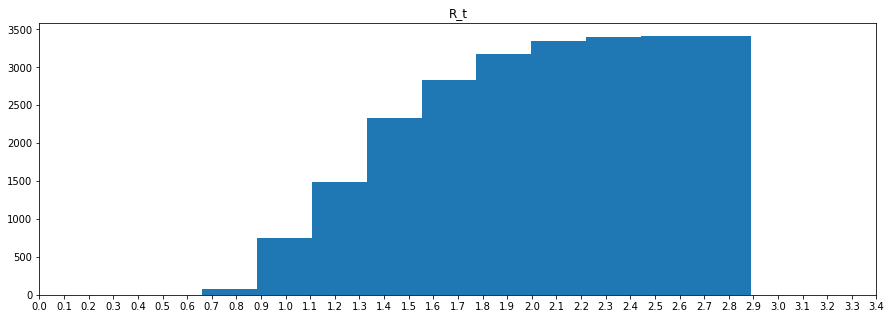

In [7]:
plt.figure(figsize=(15,5))
plt.hist(all_inputs_df['RtIndicator'], bins=10, cumulative=True)
plt.xticks(np.arange(0, 3.5, 0.1))
plt.title('R_t')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dates shared across all regions: 2020-03-14 00:00:00 - 2020-05-08 00:00:00, spanning 55 days
Latest data start date regions: ['South Dakota']
Earliest data end date regions: ['Idaho', 'Delaware']
12 states currently at or under half (smoothed) their peak daily cases: ['Connecticut', 'Michigan', 'New Jersey', 'Louisiana', 'Idaho', 'Nevada', 'Montana', 'Washington', 'Alaska', 'New York', 'Vermont', 'West Virginia']
Plot of confirmed cases per date
Number of states where daily cases are currently at their max: 20


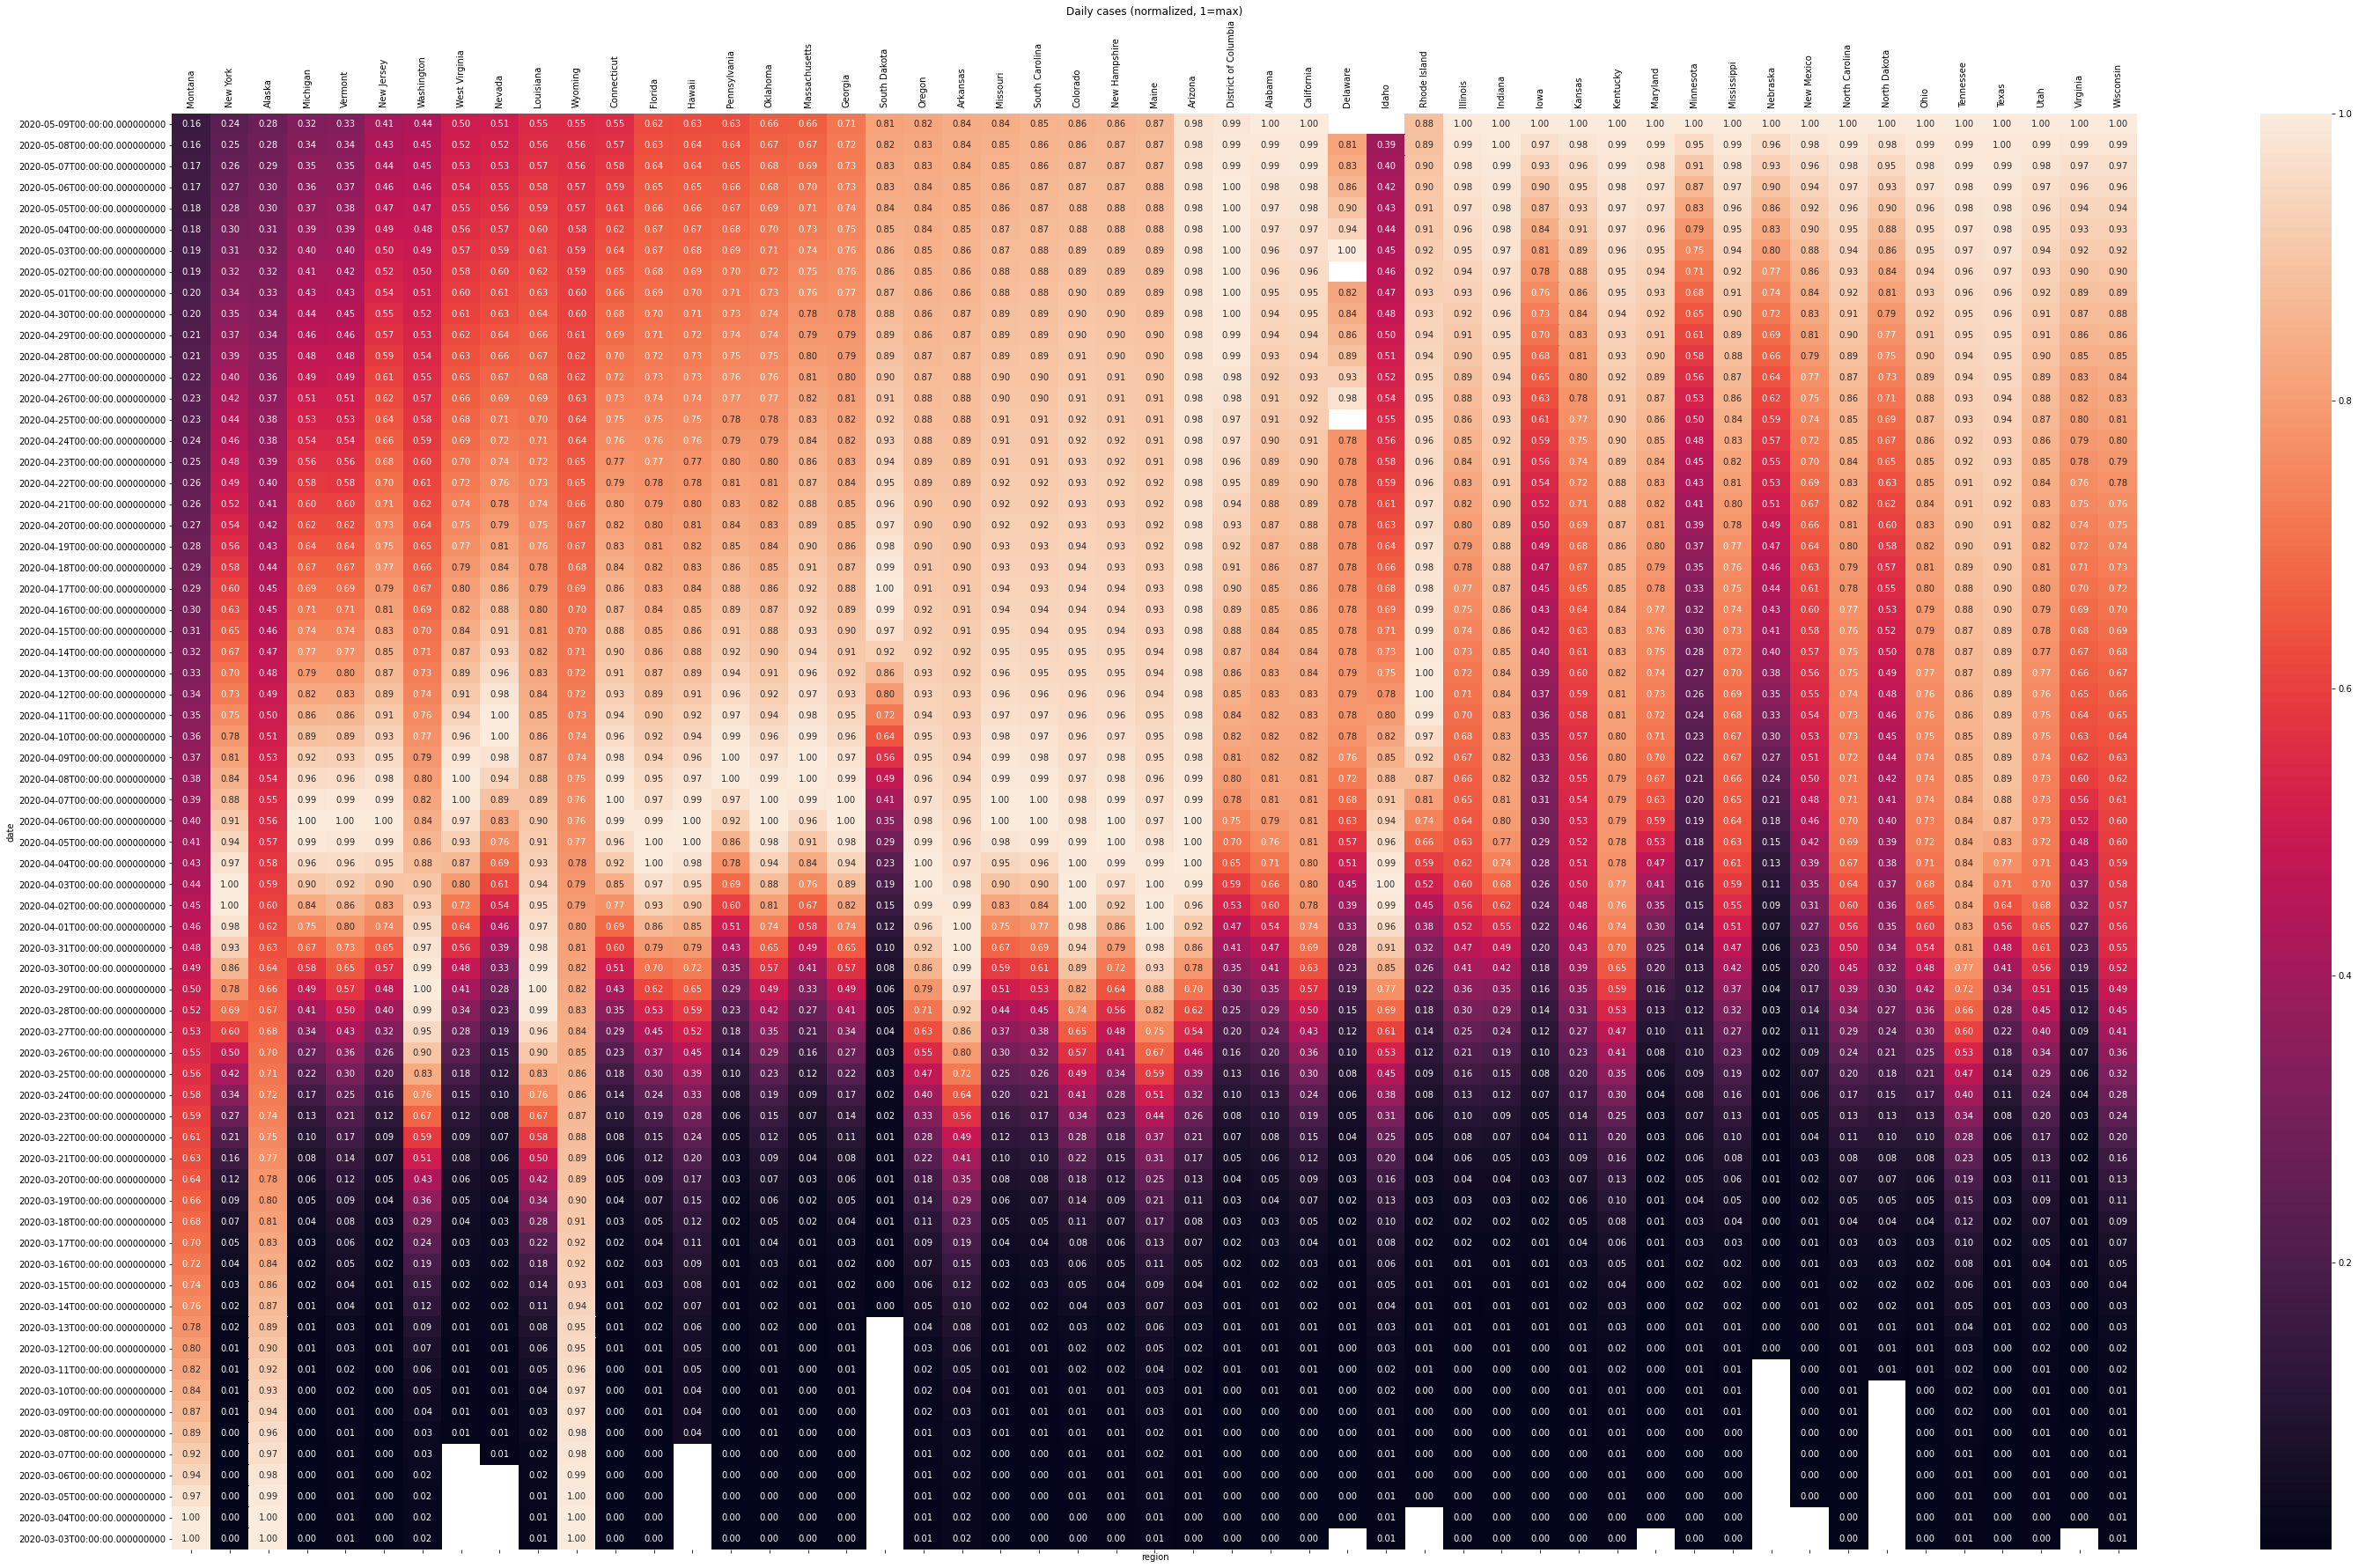

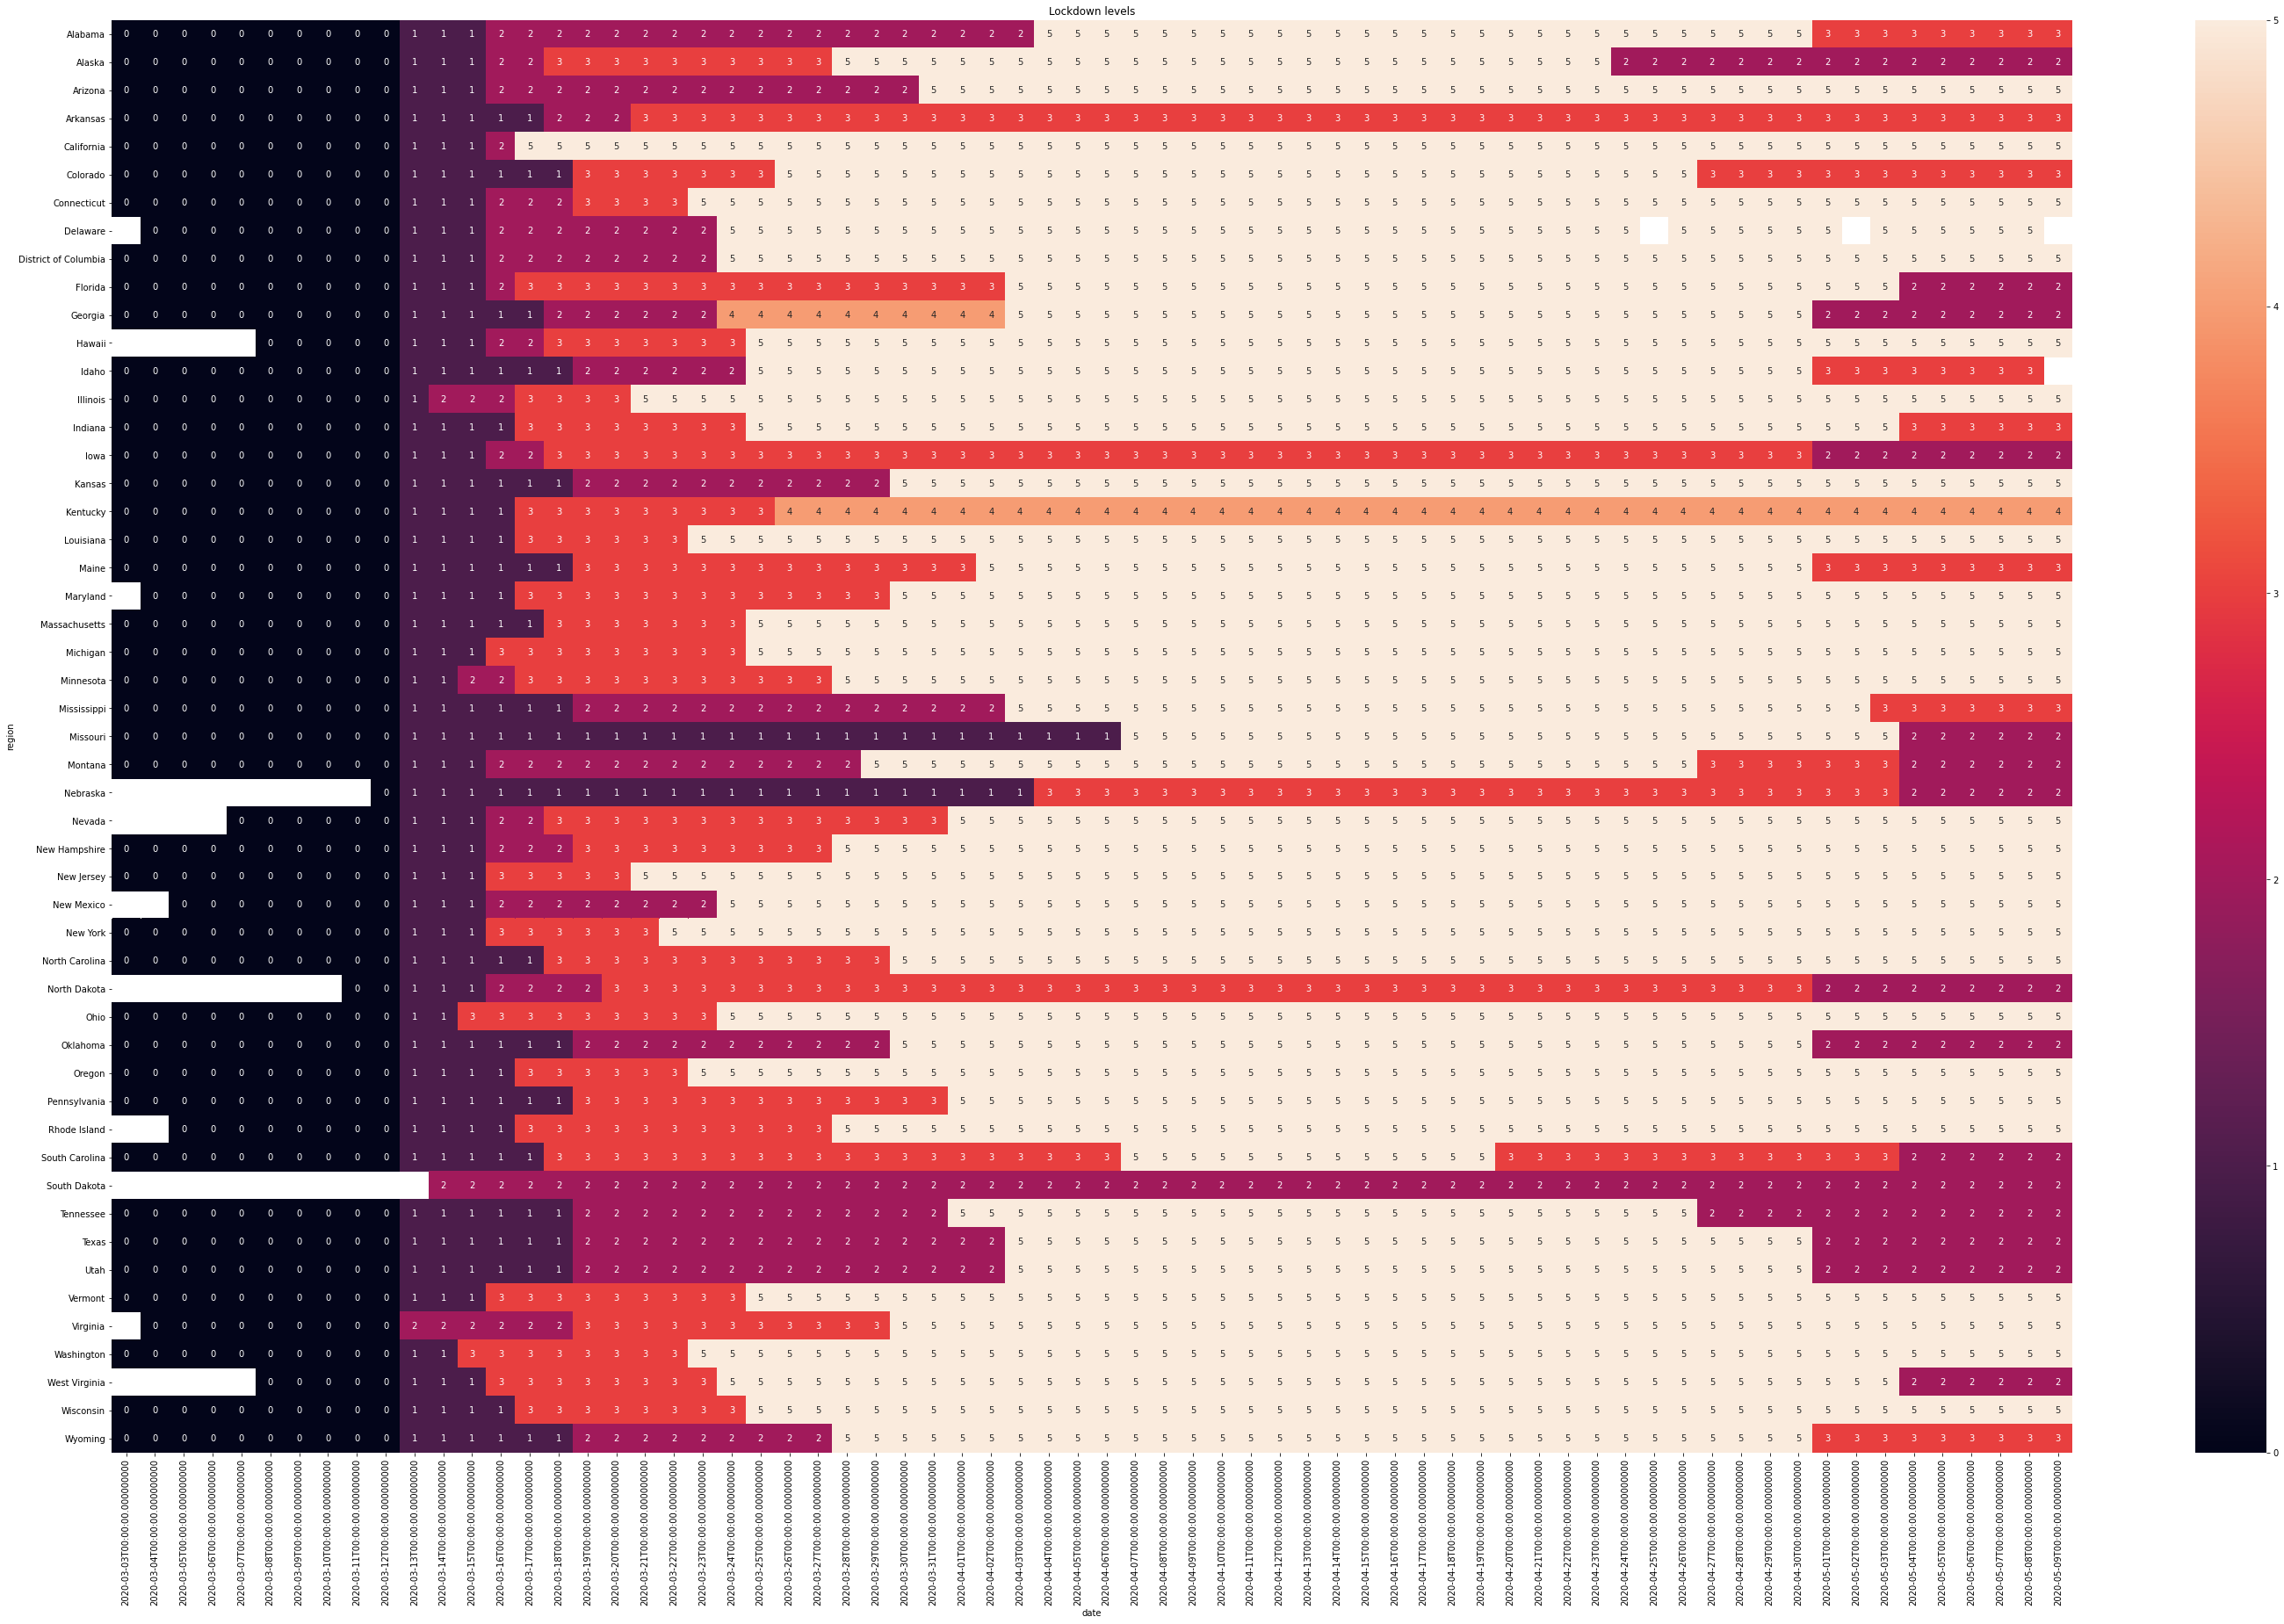

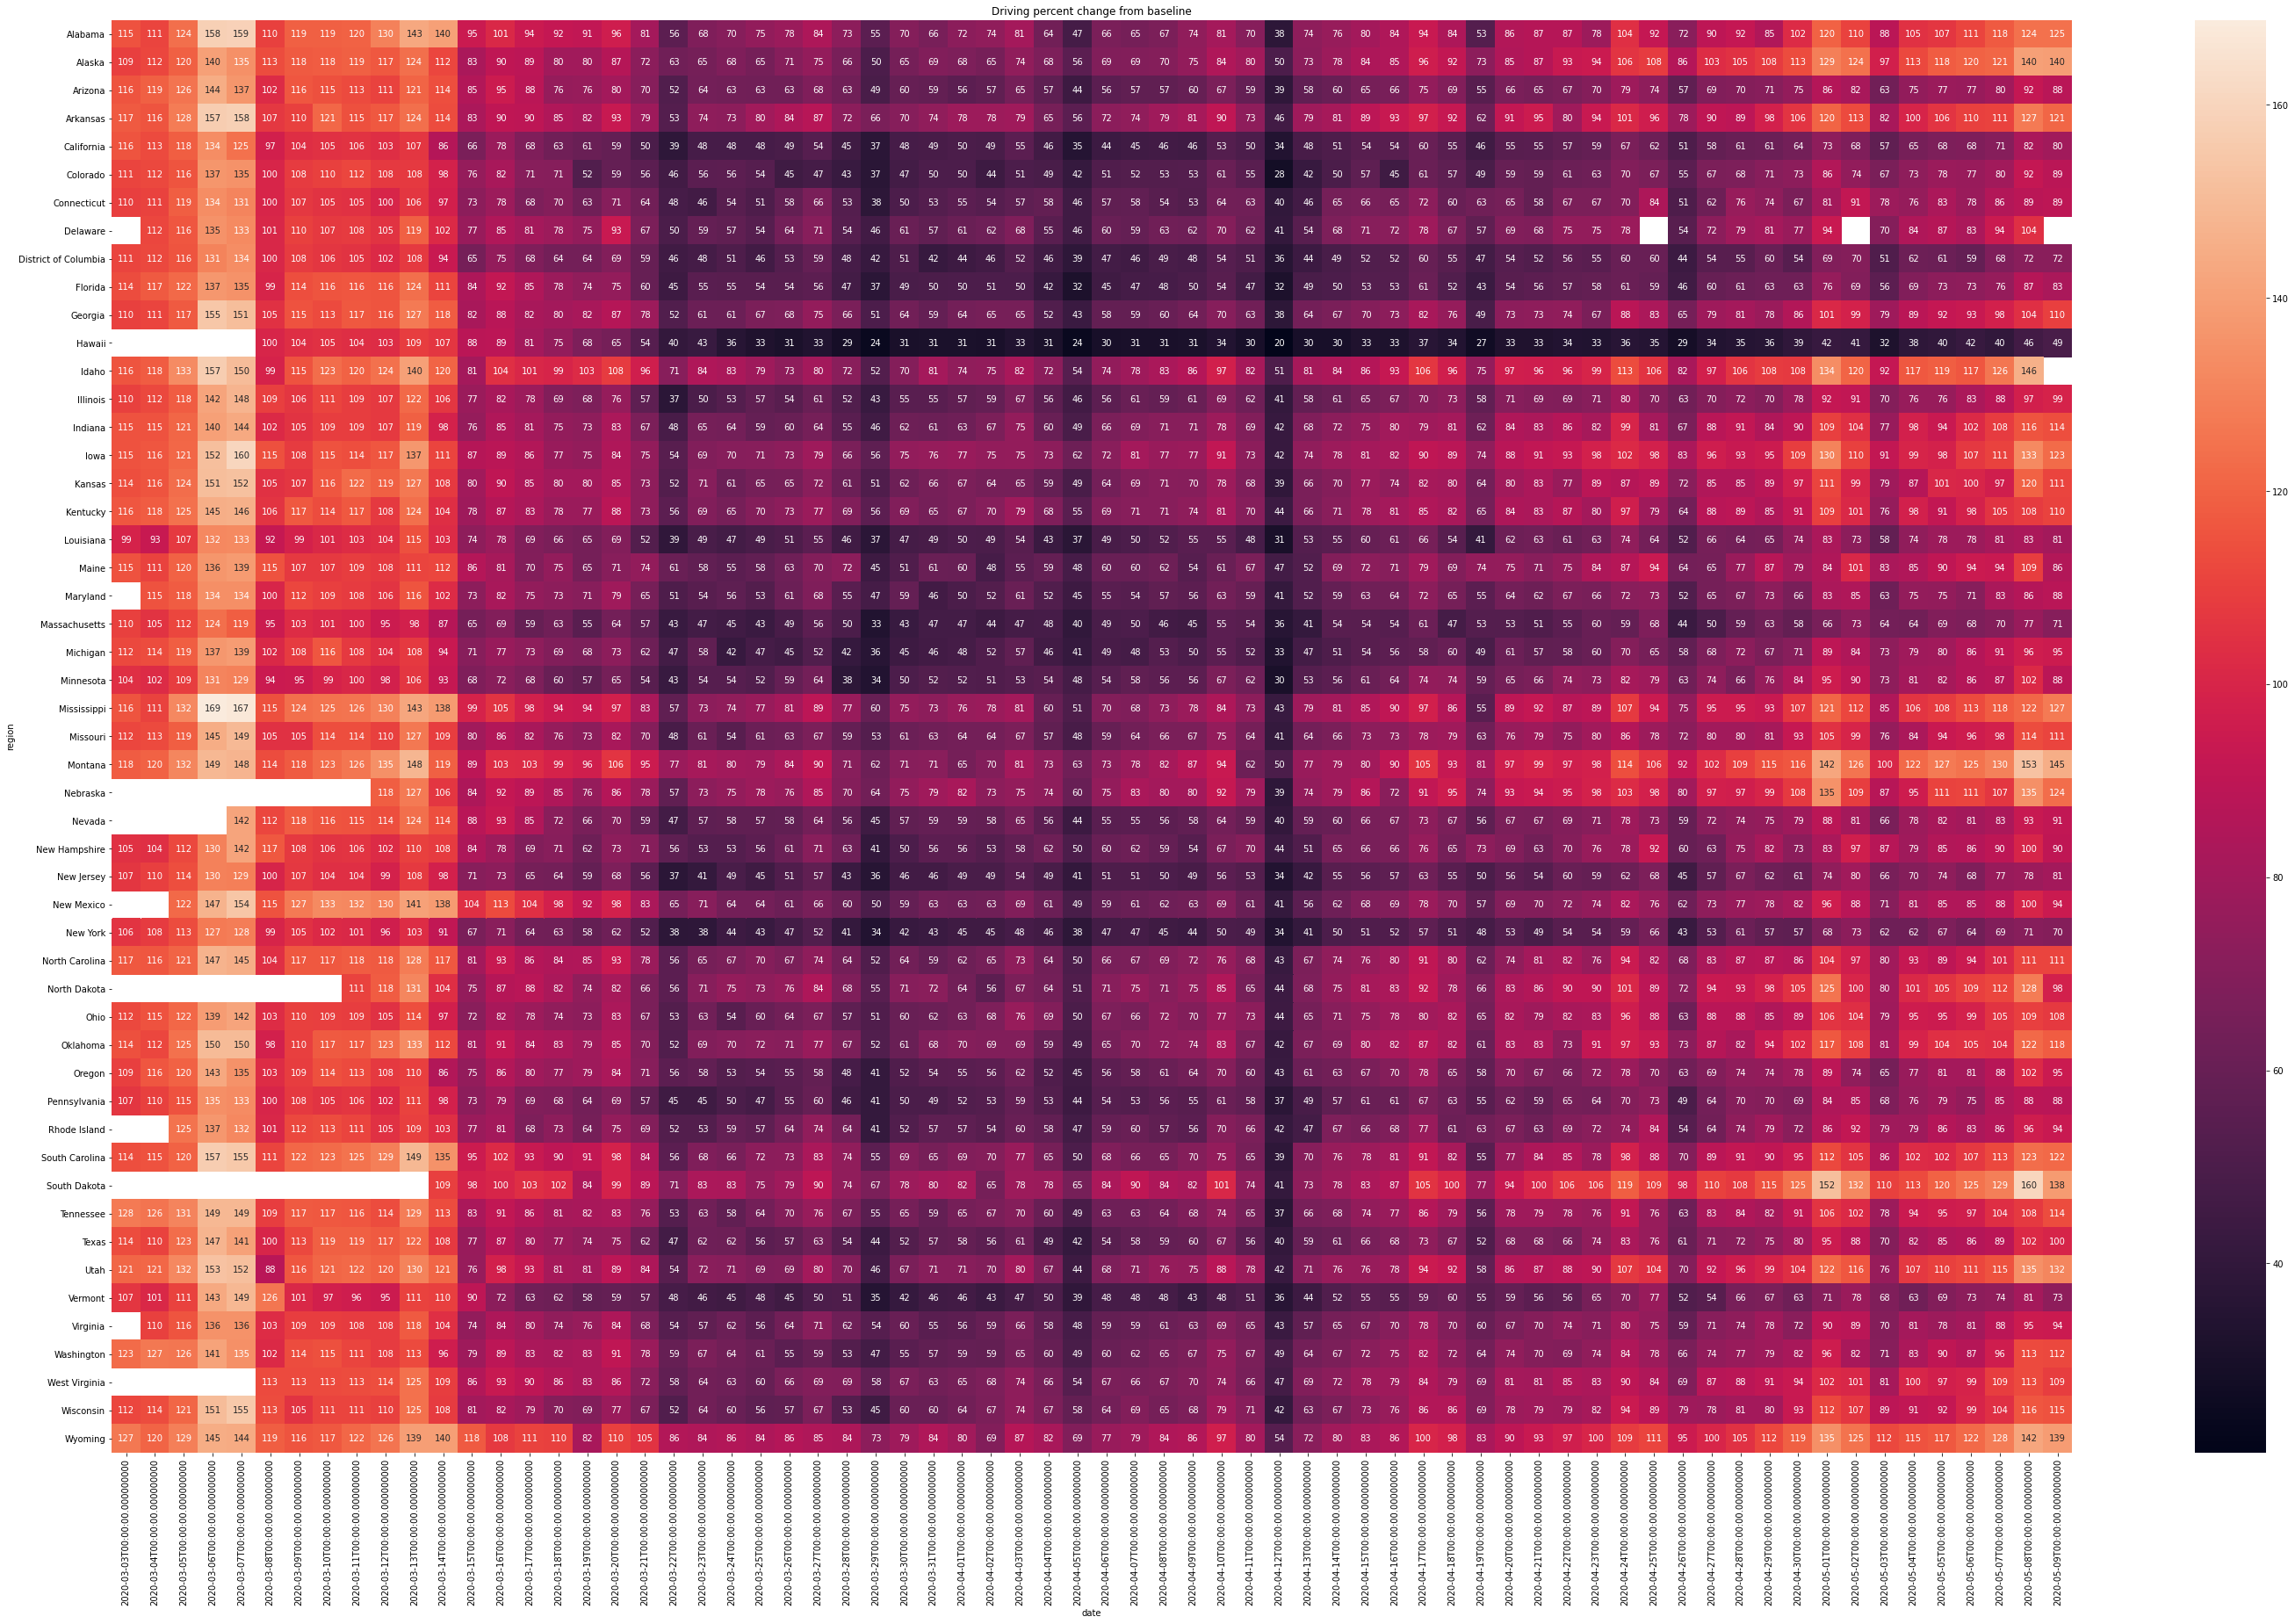

In [8]:
import seaborn as sns

def eda():
    latest_starting_date = pd.to_datetime('2019')
    latest_starting_regions = []
    earliest_ending_date = pd.to_datetime('now')
    earliest_ending_regions = []

    max_daily_equals_most_recent = []
    half_max_cases = []
    for region in inputs:
        #if region == 'South Dakota' or region=='Delaware': continue
        if min(inputs[region]['date']) > latest_starting_date:
            latest_starting_regions = [region]
            latest_starting_date = min(inputs[region]['date'])
        elif min(inputs[region]['date']) == latest_starting_date:
            latest_starting_regions.append(region)

        if max(inputs[region]['date']) < earliest_ending_date:
            earliest_ending_regions = [region]
            earliest_ending_date = max(inputs[region]['date'])
        elif max(inputs[region]['date']) == earliest_ending_date:
            earliest_ending_regions.append(region)

        if inputs[region]['daily_cases'].values[-1] == inputs[region]['daily_cases'].max(): max_daily_equals_most_recent.append(region)
        if inputs[region]['daily_cases_ewm_avg'].values[-1] <= inputs[region]['daily_cases'].max() * .5: half_max_cases.append(region)
    print(f"Dates shared across all regions: {latest_starting_date} - {earliest_ending_date}, spanning {(earliest_ending_date - latest_starting_date).days} days")
    print(f"Latest data start date regions: {latest_starting_regions}")
    print(f"Earliest data end date regions: {earliest_ending_regions}")
    print(f"{len(half_max_cases)} states currently at or under half (smoothed) their peak daily cases: {half_max_cases}")
    print(f"Plot of confirmed cases per date")
    
    plt.show()

    print(f"Number of states where daily cases are currently at their max: {len(max_daily_equals_most_recent)}")
eda()

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#date_formatter = DateFormatter("%y-%m-%d")

daily_pivot = all_inputs_df.pivot_table(index="date", columns=["region"], values="daily_cases_ewm_avg")
daily_pivot = daily_pivot.iloc[::-1] # put most recent daily cases at top of graph
daily_pivot_normalized = daily_pivot.div(daily_pivot.max(axis=0), axis=1) # normalize to unit max

fig, ax = plt.subplots(1,1,figsize=(50,30), facecolor='w')
order = list(daily_pivot_normalized.transpose().index)
order = sorted(order, key = lambda region: daily_pivot_normalized[region].values[0])
daily_pivot_normalized = daily_pivot_normalized.reindex(index=daily_pivot_normalized.index, columns=order)
sns.heatmap(daily_pivot_normalized, annot=True, fmt=".2f", ax=ax)

ax.tick_params(labelbottom=False,labeltop=True)
ax.set_title('Daily cases (normalized, 1=max)')
ax.tick_params(axis='x', labelrotation=90)
#ax.xaxis.set_major_formatter(date_formatter)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.show()

lockdown_level_pivot = all_inputs_df.pivot("region", "date", "lockdown_level")
fig, ax = plt.subplots(1,1, figsize=(50,30), facecolor='w')
sns.heatmap(lockdown_level_pivot, annot=True, ax=ax)
ax.set_title('Lockdown levels')
#ax.xaxis.set_major_formatter(date_formatter)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.show()

driving_pivot = all_inputs_df.pivot('region', 'date', 'driving_percent')*100 + 100
fig, ax = plt.subplots(1,1, figsize=(50,30), facecolor='w')
sns.heatmap(driving_pivot, annot=True, fmt=".0f", ax=ax)
ax.set_title('Driving percent change from baseline')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [0]:
!pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-cp36-none-any.whl size=5315 sha256=93900ea8c294a985f2e2887566fa76f878d69f698990b7f1e526398d057a007d
  Stored in directory: /root/.cache/pip/wheels/8c/8b/7a/947d67b53cd54948890a173527b0470ef56998812fc9d0a803
Successfully built dtw


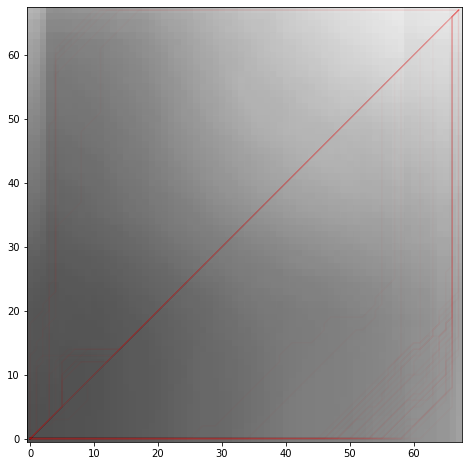

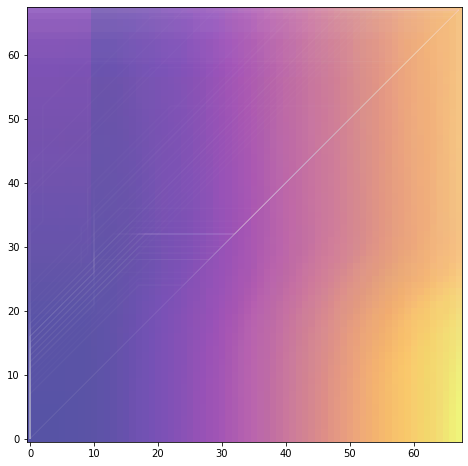

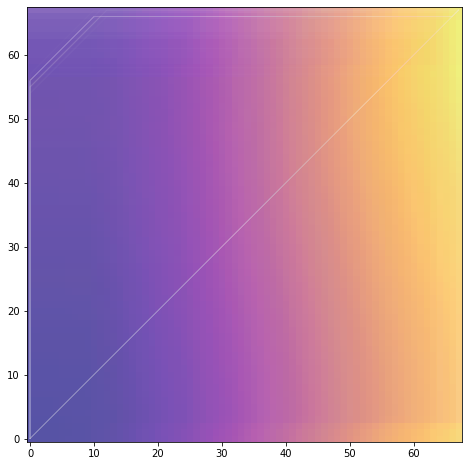

In [0]:
from dtw import dtw
from scipy.spatial.distance import euclidean
def dtw_driving():
    #fig, ax = plt.subplots(11, 5, figsize=(110, 50))

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    # make a dtw matrix corresponding to alignment between driving and daily cases
    # overlay all driving dtw alignments onto 1 plot
    curves_x = []
    curves_y = []
    for i, region in enumerate(inputs):
        #row, col = i // 5, i % 5
        x = inputs[region]['driving_percent'].values.reshape(-1,1)
        y = (inputs[region]['daily_cases'] / inputs[region]['daily_cases'].max()).values.reshape(-1,1)
        distance, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean)
        #print(distance)
        #ax[row, col].imshow(acc_cost_matrix.T, origin='lower', interpolation='nearest')
        #ax[row, col].plot(path[0], path[1], c='red')
        plt.imshow(acc_cost_matrix.T, origin='lower', alpha=1/len(inputs), cmap='gray')
        ax.plot(path[0], path[1], alpha=1/len(inputs), c='r')
        # curves_x.append(path[0])
        # curves_y.append(path[1])
    #plt.tight_layout()
    #plt.show()
    #curves_avg = [np.mean(np.array(curves_x), axis=0), np.mean(np.array(curves_y), axis=0)]
    #ax.plot(curves_avg[0], curves_avg[1], c='b')
    plt.show()
dtw_driving()

def dtw_lockdown_level():
    #fig, ax = plt.subplots(11, 5, figsize=(110, 50))

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    # make a dtw matrix corresponding to alignment between driving and daily cases
    # overlay all driving dtw alignments onto 1 plot
    for i, region in enumerate(inputs):
        #row, col = i // 5, i % 5
        x = inputs[region]['lockdown_level'].values.reshape(-1,1)
        y = (inputs[region]['daily_cases'] / inputs[region]['daily_cases'].max()).values.reshape(-1,1)
        distance, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean)
        #print(distance)
        #ax[row, col].imshow(acc_cost_matrix.T, origin='lower', interpolation='nearest')
        #ax[row, col].plot(path[0], path[1], c='red')
        plt.imshow(acc_cost_matrix.T, origin='lower', alpha=1/len(inputs), cmap='plasma')
        ax.plot(path[0], path[1], alpha=1/len(inputs), c='w')
    plt.show()
dtw_lockdown_level()

def dtw_lockdown_level_driving():
    #fig, ax = plt.subplots(11, 5, figsize=(110, 50))

    fig, ax = plt.subplots(1,1,figsize=(8,8))
    # make a dtw matrix corresponding to alignment between driving and daily cases
    # overlay all driving dtw alignments onto 1 plot
    for i, region in enumerate(inputs):
        #row, col = i // 5, i % 5
        x = inputs[region]['lockdown_level'].values.reshape(-1,1)
        y = inputs[region]['driving_percent'].values.reshape(-1,1)
        distance, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean)
        #print(distance)
        #ax[row, col].imshow(acc_cost_matrix.T, origin='lower', interpolation='nearest')
        #ax[row, col].plot(path[0], path[1], c='red')
        plt.imshow(acc_cost_matrix.T, origin='lower', alpha=1/len(inputs), cmap='plasma')
        ax.plot(path[0], path[1], alpha=1/len(inputs), c='w')
    plt.show()

dtw_lockdown_level_driving()

# Silly SGD regression

In [0]:
params = ['driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
          'grocery_and_pharmacy_percent_change_from_baseline', 
          'transit_stations_percent_change_from_baseline',
          'workplaces_percent_change_from_baseline', 
          'residential_percent_change_from_baseline', 
          'lockdown_level', 'poverty', 'age', 'income',
          'healthcare', 'healthcareLow', 'healthcareHigh',
          'obesity', 'smokes', 'smokesLow', 'smokesHigh',
          'Density per square mile of land area']
X = inputs['Alabama'][params].values
X = np.hstack((X, np.arange(len(X)).reshape((-1,1))))
y = inputs['Alabama'][['RtIndicator']].values
print(X.shape,y.shape)
reg = LinearRegression(normalize=True).fit(X, y)
reg.score(X,y)

(54, 19) (54, 1)


0.9323713273227463

In [0]:
regression_coefs = {param: [] for param in params + ['t', 't^2']}
intercepts = []
#X_tot = None
#y_tot = np.array([])
for region in USA:
    #print(f"cols with nans: {inputs[region][params].columns[inputs[region][params].isna().any()].tolist()}")
    X = inputs[region][params].values
    t = np.arange(len(X)).reshape((-1,1))
    X = np.hstack((X, t, np.square(t)))
    
    #y = np.diff(np.log(inputs[region][['cumulativeDeaths']].values + 1e-9), axis=0)
    y = inputs[region][['RtIndicator']].values.ravel()
    
    # if type(X_tot) == type(None): X_tot = X
    # else: 
    #     print(X_tot.shape, X.shape)
    #     X_tot = np.concatenate((X_tot, X), axis=0)
    # y_tot = np.hstack((y_tot,y))

    #X_tot = preprocessing.StandardScaler().fit(X_tot).transform(X_tot)
    X = preprocessing.StandardScaler().fit(X).transform(X)
    reg = SGDRegressor(max_iter=100000).fit(X, y)
    
    print(f"regression for {region}")
    print(reg.score(X,y))
    # pprint.pprint({param:reg.coef_[0][i] for i, param in enumerate(params + ['t'])})
    for i, param in enumerate(params + ['t', 't^2']):
        regression_coefs[param].append(reg.coef_[i])
        intercepts.append(reg.intercept_)

print(f"b={sum(intercepts)/len(intercepts)}")
for i, param in enumerate(regression_coefs):
    coefs = regression_coefs[param]
    if len(coefs) > 0:
        print(f"{param}: \n\t median = {np.median(coefs)} \n\t min = {np.min(coefs)} \n\t mean = {np.mean(coefs)} \n\t max = {np.max(coefs)} \n")

regression for Georgia
0.9544244823114347
regression for Massachusetts
0.8783847443167101
regression for Tennessee
0.8631053745944031
regression for Nebraska
0.7493690863310334
regression for Texas
0.9345094324839051
regression for Idaho
0.8316924752392272
regression for Hawaii
0.937609567297665
regression for Virginia
0.830185595281324
regression for Alaska
0.8377141836192342
regression for District of Columbia
0.8784397333824948
regression for Alabama
0.86665182851688
regression for Iowa
0.6404233645684081
regression for Missouri
0.8640456442651195
regression for Nevada
0.8881814299092523
regression for New York
0.8381761596713927
regression for Wyoming
0.8103912740608632
regression for Kansas
0.8171790387520842
regression for Delaware
0.8871815828781672
regression for North Carolina
0.9253265893049334
regression for South Dakota
0.8405192416633244
regression for South Carolina
0.7869217610039074
regression for Michigan
0.7519423436831777
regression for North Dakota
0.704624718482350

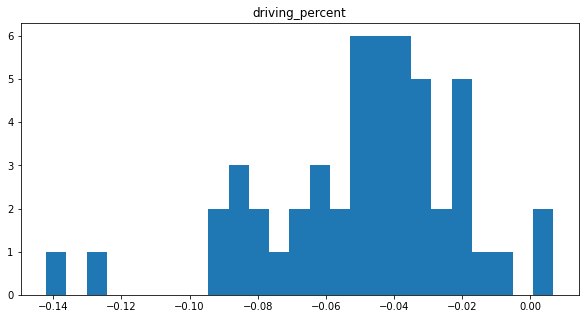

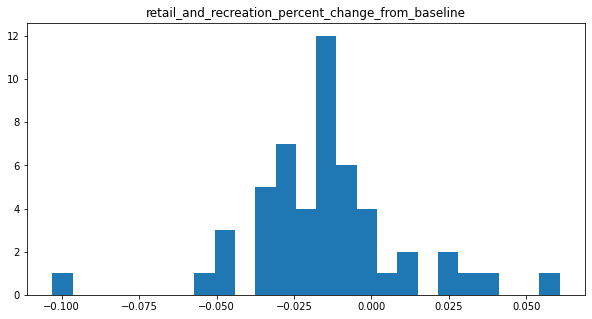

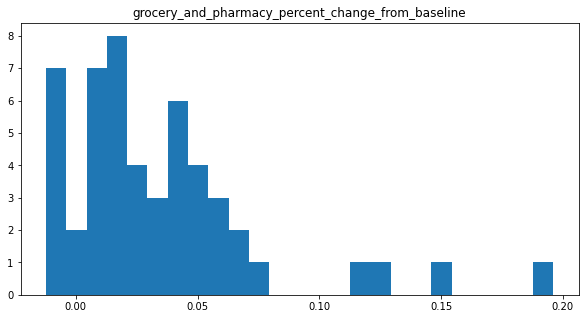

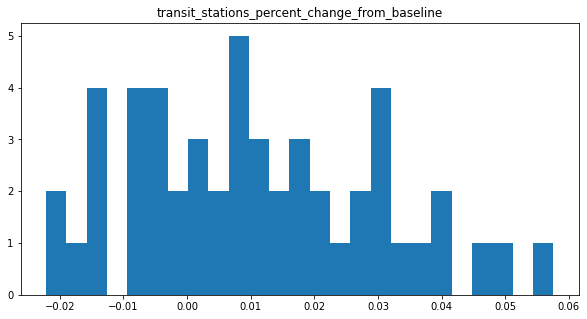

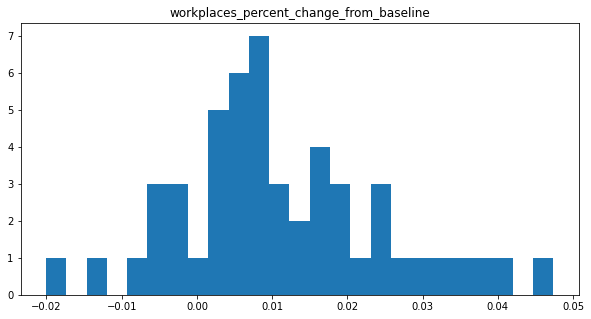

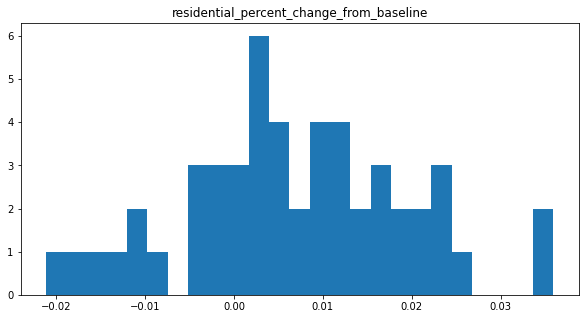

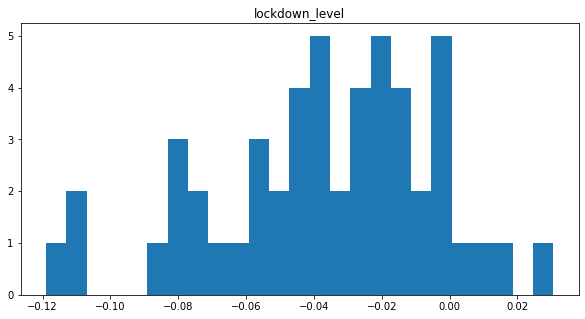

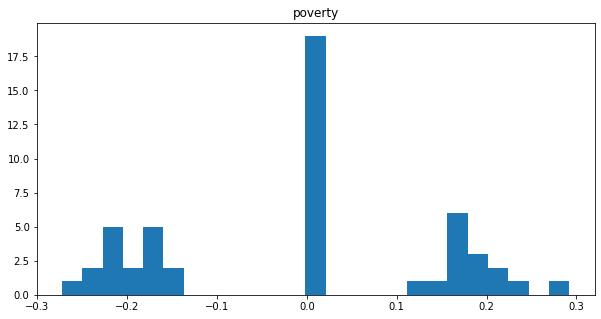

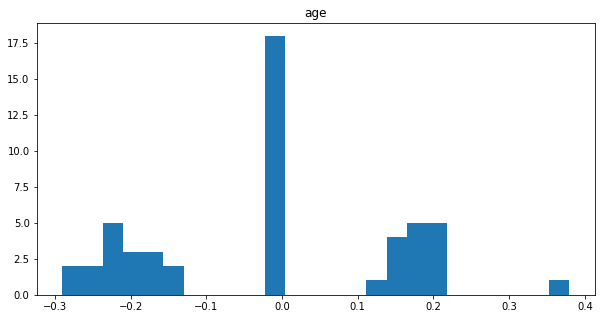

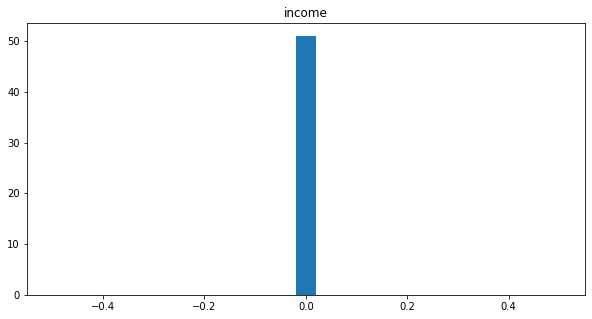

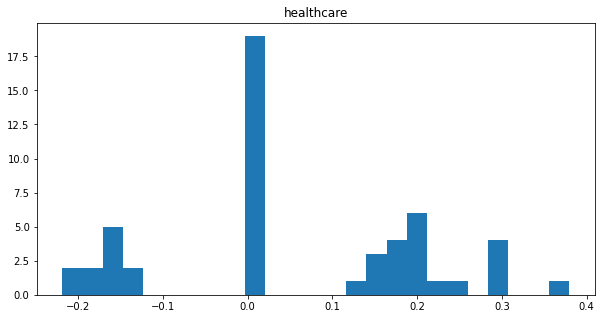

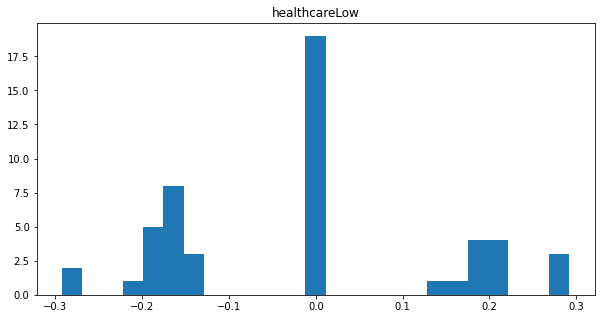

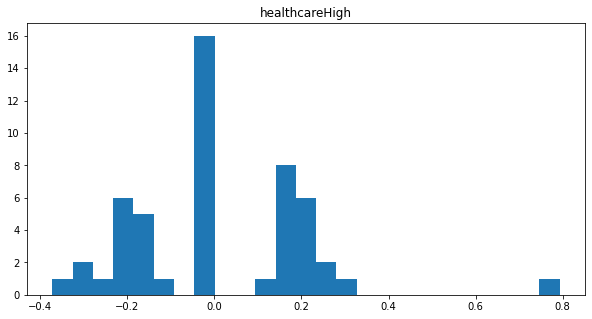

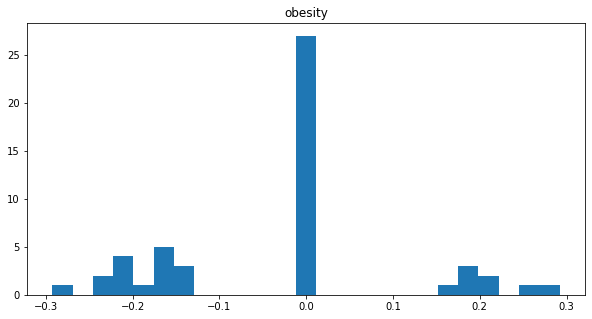

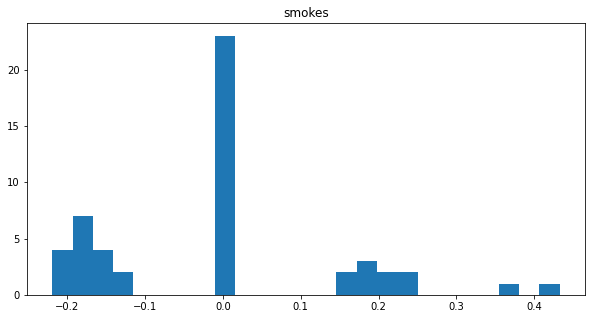

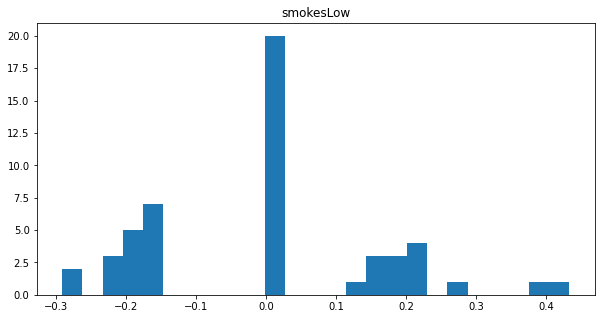

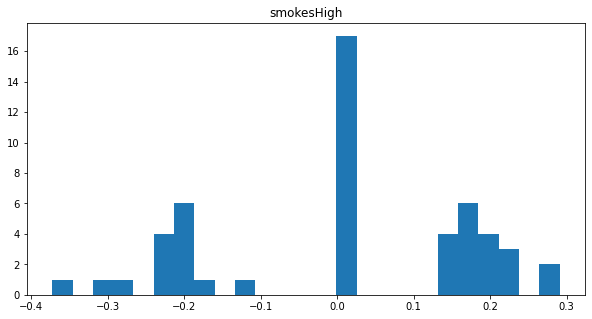

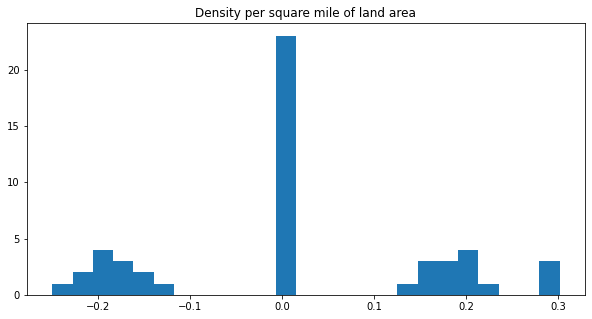

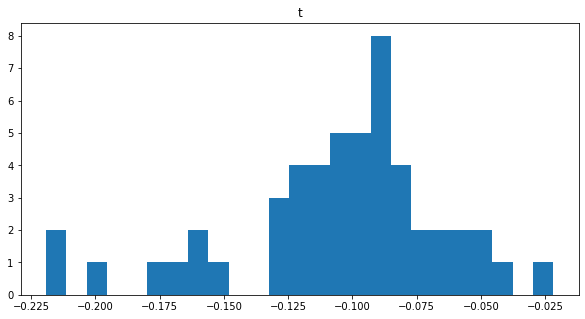

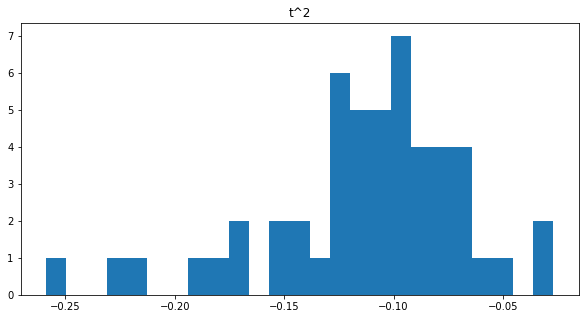

In [0]:

for i, param in enumerate(params + ['t', 't^2']):
    plt.figure(figsize=(10,5))
    plt.hist(regression_coefs[param], bins=25)
    plt.title(param)
    plt.show()

    prev_hidden                              ----------> |i2o| ---------------> output
        +        -----> |input2hidden1| -----|
      input                                  ----------> |input2hidden2|------> hidden

# Bad LSTM model


In [0]:

import torch.nn.functional as F
class LSTM(nn.Module):
    # adapted from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
    def __init__(self, input_dim, hidden_dim1, seq_len=14, output_dim = 2, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.output_dim = output_dim
        self.seq_len = seq_len

        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim1, self.num_layers, dropout=0)

        # define output layer
        self.linear1 = nn.Linear(self.hidden_dim1, self.output_dim)
        #self.linear2 = nn.Linear(self.hidden_dim2, self.output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1),
                torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1))
    
    def forward(self, input):
        # lstm_out shape: [input_size, batch_size, hidden_dim]
        # self.hidden shape: (a, b)
        # where a and b both have shape (num_layers, batch_size, hidden_dim)
        #print(input.shape)
        lstm_out, self.hidden = self.lstm(
            input.reshape(len(input), self.seq_len, -1))
        y_pred = self.linear1(lstm_out.view(self.seq_len, len(input), -1)[-1])
        return y_pred.reshape((-1, self.output_dim))


def sliding_windows(X, Y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length):
        x = X[i:(i+seq_length)]
        y = Y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)), torch.from_numpy(np.array(ys))




In [0]:
def extrapolate_r0(r0, susceptible_population, timespan=[0,1,2,3,4,5,6]):
    infected = np.power(r0, timespan) * susceptible_population
    #plt.plot(infected)
    return infected
#extrapolate_r0(y_pred[-1][0].detach().numpy(), 100)

In [0]:
def build_state_model(region):
    print(f"starting {region}")
    input_params = [
        'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline', 
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline', 
        'residential_percent_change_from_baseline', 
        'lockdown_level', 'lat', 'long', 
        'lockdown_level_0',
        'lockdown_level_1',
        'lockdown_level_2',
        'lockdown_level_3',
        'lockdown_level_4',
        'lockdown_level_5',
        'lockdown_level_6',
        'hospitalBedsRequired', 'hospitalBedCapacity',
        'ventilatorsInUse', 'ventilatorCapacity',
        'ICUBedsInUse', 'ICUBedCapacity',
        'poverty', 'age', 'income',
        'healthcare', 'healthcareLow', 'healthcareHigh',
        'obesity', 'smokes', 'smokesLow', 'smokesHigh',
        'Density per square mile of land area',
        'positive_test_rate', 'urbanization',
        'cumulativeDeaths', 'cumulativeInfected', 
        'cumulativePositiveTests', 'cumulativeNegativeTests',# 'RtIndicator']
        'daily_cases', '2018 Population']
    output_params = ['infection_acceleration']
    seq_len = 10

    X = inputs[region][input_params].values.astype('float32')
    X = preprocessing.StandardScaler().fit(X).transform(X)
    Y = np.identity(2)[inputs[region][output_params].values.astype('long')[:, 0]]
    
    
    test_size = 15
    
    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[test_size:]

    X_train_lstm, y_train_lstm = sliding_windows(X_train, Y_train, seq_len)
    X_test_lstm, y_test_lstm = sliding_windows(X_test, Y_test, seq_len)
    
    hidden1 = 15
    print(len(input_params))
    model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = 2, num_layers=2)

    loss_fn = torch.nn.BCEWithLogitsLoss()
    learning_rate = 1e-3
    num_epochs = 2000
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #####################
    # Train model
    #####################
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    train_losses = [] 
    test_losses = []
    for t in range(num_epochs):
        # Clear stored gradient

        model.zero_grad()
        
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        model.hidden = model.init_hidden()
        
        # Forward pass
        y_pred = model(X_train_lstm)
    
        train_loss = loss_fn(y_pred, y_train_lstm)
        train_losses.append(train_loss)
        
        with torch.no_grad():
            y_test_pred = model(X_test_lstm)
            test_loss = loss_fn(y_test_pred, y_test_lstm)
        test_hist[t] = test_loss.item()
        train_hist[t] = train_loss.item()
    
        if t % 50 == 0:
            print("Epoch ", t, "train loss: ", train_loss.item(), "test loss: ", test_loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        # Update parameters
        optimiser.step()
    plt.plot(train_losses)
    plt.title(f'{region} loss curve')
    plt.show()
    print(f"y_pred: {y_pred}")
    print("prediction vs actual:")
    
    pprint.pprint(list(zip(np.argmax(torch.sigmoid(y_test_pred.data), axis=1), y_test_lstm)))
    #for i, probs in enumerate(y_test_pred.data):
    series = np.argmax(torch.sigmoid(y_test_pred.data), axis=1)
    print(f"series: {series}")
    timestamps = range(len(series))
    actual = y_test_lstm[-len(series):]
    l1 = plt.plot()
    plt.plot(series)
    plt.plot(actual.reshape(-1, 1))
    plt.title(f"{region} infection acceleration {len(series)}-day interpolation")
    plt.legend(['interpolation', 'actual'])
    plt.show()
    return model


In [0]:
models = {}
for region in USA:
    models[region] = build_state_model(region)

starting South Carolina
39
Epoch  0 train loss:  0.6981469525231255 test loss:  0.6912442676723003
Epoch  50 train loss:  0.5102315391931269 test loss:  0.7837337613105774
Epoch  100 train loss:  0.4928428110563093 test loss:  0.838872817158699
Epoch  150 train loss:  0.4923451447652446 test loss:  0.8338475674390793
Epoch  200 train loss:  0.49183627342184383 test loss:  0.8312296360731125
Epoch  250 train loss:  0.4907810207870271 test loss:  0.8321579784154892
Epoch  300 train loss:  0.4874503622866339 test loss:  0.8404264181852341
Epoch  350 train loss:  0.4789483652760585 test loss:  0.8698612377047539
Epoch  400 train loss:  0.4657728452649381 test loss:  0.8815500095486641
Epoch  450 train loss:  0.44828914255938596 test loss:  0.9051555395126343
Epoch  500 train loss:  0.4363420072736012 test loss:  0.9448212295770645
Epoch  550 train loss:  0.4293681708319734 test loss:  0.9771515108644963
Epoch  600 train loss:  0.4256046081168784 test loss:  1.0154517143964767
Epoch  650 tr

KeyboardInterrupt: ignored

In [0]:
import gc; gc.collect()

355969

starting California
39
Epoch  0 train loss:  0.67726021580812 test loss:  0.7237185198813677
Epoch  50 train loss:  0.5737029736240705 test loss:  0.9929400026798249
Epoch  100 train loss:  0.5291341913657056 test loss:  1.4358789056539536
Epoch  150 train loss:  0.5227330213205682 test loss:  1.5384167954325676
Epoch  200 train loss:  0.5194938764390018 test loss:  1.6859047293663025
Epoch  250 train loss:  0.5175493220902152 test loss:  1.6374406903982162
Epoch  300 train loss:  0.5129010000576576 test loss:  1.521506142616272
Epoch  350 train loss:  0.4975243204583724 test loss:  1.1403374046087265
Epoch  400 train loss:  0.48401123988959527 test loss:  0.8502468019723892
Epoch  450 train loss:  0.46639094817348653 test loss:  0.6554596722126007


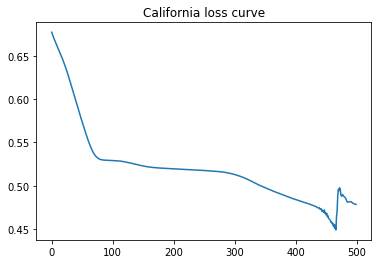

NameError: ignored

In [0]:
build_state_model('California')

In [0]:
inputs['Colorado'].tail(n=22)

In [0]:
def build_national_model():
    input_params = [
            'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
            'grocery_and_pharmacy_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline',
            'workplaces_percent_change_from_baseline', 
            'residential_percent_change_from_baseline', 
            'lockdown_level', 'lat', 'long', 
            'hospitalBedsRequired', 'hospitalBedCapacity',
            'ICUBedsInUse', 'ICUBedCapacity',
            'poverty', 'age', 'income',
            'healthcare', 'healthcareLow', 'healthcareHigh',
            'obesity', 'smokes', 'smokesLow', 'smokesHigh',
            'Density per square mile of land area',
            'positive_test_rate',
            'cumulativeDeaths', 'cumulativeInfected', 
            'cumulativePositiveTests', 'cumulativeNegativeTests',
            'RtIndicator']# + [f'state{i}' for i in range(len(USA))]

    inputs_USA = []
    for i, (region, region_df) in enumerate(inputs.items()):
        for statenumbervec in range(len(USA)):
            region_df[f"state{statenumbervec}"] = 0
        region_df[f'state{i}'] = 1
        inputs_USA.append(region_df)
    inputs_USA = pd.concat(inputs_USA, ignore_index=True)
    print(f"all columns available: {inputs_USA.columns}")
    print(f"input params: {input_params}")
    output_params = ['infection_acceleration']
    print(f"output params: {output_params}")
    seq_len = 12
    X = inputs_USA[input_params].values.astype('float32')
    X = preprocessing.MinMaxScaler().fit(X).transform(X)
    Y = inputs_USA[output_params].values.astype('long')[:, 0]
    test_size = 17

    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[test_size:]

    X_train_lstm, y_train_lstm = sliding_windows(X_train, Y_train, seq_len)
    X_test_lstm, y_test_lstm = sliding_windows(X_test, Y_test, seq_len)

    hidden1 = 100
    print(len(input_params))
    model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = 2, num_layers=2)

    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 2e-3
    num_epochs = 100
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #####################
    # Train model
    #####################

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    train_losses = [] 
    test_losses = []
    for t in range(num_epochs):
        # Clear stored gradient

        model.zero_grad()
        
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()
        
        # Forward pass
        y_pred = model(X_train_lstm)

        train_loss = loss_fn(y_pred, y_train_lstm)
        train_losses.append(train_loss)
        
        with torch.no_grad():
            y_test_pred = model(X_test_lstm)
            test_loss = loss_fn(y_test_pred, y_test_lstm)
        test_hist[t] = test_loss.item()
        train_hist[t] = train_loss.item()

        if t % 2 == 0:
            print("Epoch ", t, "train MSE: ", train_loss.item(), "test MSE: ", test_loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        # Update parameters
        optimiser.step()
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.show()
    print("prediction vs actual:")
    pprint.pprint(list(zip(y_test_pred.data, y_test_lstm)))
    for i, input_param in enumerate(input_params):
        print(f"{input_param}: {X_test_lstm[-1, -1, i]}")
    return model, train_losses, test_losses, X, Y

model, train_losses, test_losses, X, Y = build_national_model()


all columns available: Index(['region', 'date', 'driving_percent',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'hospitalBedsRequired',
       ...
       'state41', 'state42', 'state43', 'state44', 'state45', 'state46',
       'state47', 'state48', 'state49', 'state50'],
      dtype='object', length=110)
input params: ['driving_percent', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'lockdown_level', 'lat', 'long', 'hospitalBedsRequired', 'hospitalBedCapacity', 'ICUBedsInUse', 'ICUBedCapacity', 'poverty', 'age', 'income

KeyboardInterrupt: ignored

In [0]:
{param: X_lstm[-1][-1][i] for i, param in enumerate(params)}

{'Density per square mile of land area': tensor(0.),
 'age': tensor(0.),
 'driving_percent': tensor(-0.0139),
 'grocery_and_pharmacy_percent_change_from_baseline': tensor(-0.2063),
 'healthcare': tensor(0.),
 'healthcareHigh': tensor(0.),
 'healthcareLow': tensor(0.),
 'income': tensor(0.),
 'lockdown_level': tensor(0.6364),
 'obesity': tensor(0.),
 'poverty': tensor(0.),
 'residential_percent_change_from_baseline': tensor(0.0215),
 'retail_and_recreation_percent_change_from_baseline': tensor(-0.4084),
 'smokes': tensor(0.),
 'smokesHigh': tensor(0.),
 'smokesLow': tensor(0.),
 'transit_stations_percent_change_from_baseline': tensor(-0.4709),
 'workplaces_percent_change_from_baseline': tensor(-0.6537)}

In [0]:
#import gc; gc.collect()
X_lstm[-1]

In [0]:
params

['driving_percent',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'lockdown_level',
 'poverty',
 'age',
 'income',
 'healthcare',
 'healthcareLow',
 'healthcareHigh',
 'obesity',
 'smokes',
 'smokesLow',
 'smokesHigh',
 'Density per square mile of land area']

(array([ 5.,  5., 10.,  9.,  3.,  5.,  5.,  2.,  3.,  4.]),
 array([39680. , 43109.1, 46538.2, 49967.3, 53396.4, 56825.5, 60254.6,
        63683.7, 67112.8, 70541.9, 73971. ]),
 <a list of 10 Patch objects>)

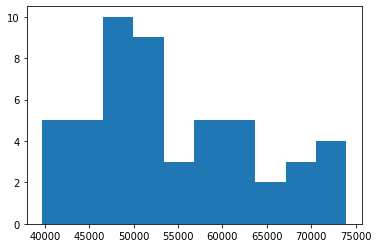

In [0]:
plt.hist([inputs[region]['income'][0] for region in inputs])

In [0]:
list(zip(inputs['Michigan']['RtIndicator'], y_pred))

# Temporal Convolutional Network

In [0]:
from tensorflow.keras.layers import Dense
import tensorflow.keras.layers as layers
from tensorflow.keras.activations import softplus
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as metrics
import tensorflow

from tcn import TCN, tcn_full_summary


def sliding_windows_TF(X, Y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length - 1):
        x = X[i:(i+seq_length)]
        y = Y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class TCNModel: # classifier
    def __init__(self, X_train, y_train, seq_len, test_size, X_train_const, X_test=None, y_test=None, title='', epochs=100, validation_pct=0.3):
        # seq inputs shape = [batch#, #timesteps, #features]
        self.X_scaler = preprocessing.MinMaxScaler()
        self.X_scaler.fit(X_train)
        self.X_const_scaler = preprocessing.MinMaxScaler()
        self.X_const_scaler.fit(X_train_const)
        X_train = self.X_scaler.transform(X_train)
        X_train_const = self.X_const_scaler.transform(X_train_const)
        if type(X_test) != type(None): X_test = self.X_scaler.transform(X_test)
        # mapping = {0: [0,0,0,0,0],
        #            1: [1,0,0,0,0],
        #            2: [1,1,0,0,0],
        #            3: [1,1,1,0,0],
        #            4: [1,1,1,1,0],
        #            5: [1,1,1,1,1]}
        #y_train = [mapping[y_val] for y_val in y_train[:, 0]]
        #print(f"X.shape: {X.shape} y.shape: {y.shape}")
        self.X_train_seq, self.y_train_seq = sliding_windows_TF(X_train, y_train, seq_len)
        self.X_train_const = X_train_const
        self.X_train_const_seq, _ = sliding_windows_TF(X_train_const, y_train, seq_len)
        print(f"self.y_train_seq[-5:]: {self.y_train_seq[-5:]}")
        print(f"X_train_seq.shape: {self.X_train_seq.shape} y_train_seq.shape: {self.y_train_seq.shape}")
        if type(X_test) != type(None) and type(y_test) != type(None): 
            self.X_test_seq, self.y_test_seq = sliding_windows_TF(X_test, y_test, seq_len)
            print(f"X_test_seq.shape: {self.X_test_seq.shape} y_test_seq.shape: {self.y_test_seq.shape}")
        batch_size = len(self.X_train_seq) 
        
        timesteps = seq_len
        input_dim = len(self.X_train_seq[0][0])
        #output_dim = 5 #len(self.y_train_seq[0]) # <- ordinal classifier
        output_dim = 1 # <- binary acceleration classifier
        const_features_dim = X_train_const.shape[1]
        print(batch_size, timesteps, input_dim, const_features_dim)
        
        self.i_seq = Input(batch_shape=(None, seq_len, input_dim), name='timeseries')
        self.i_const = Input((seq_len, const_features_dim,), name='constants')
        
        #self.i_const = layers.Flatten()(self.i_const)
        #self.o = TCN(return_sequences=False, dilations=[1, 2, 3, 4, 5], nb_stacks = 2, nb_filters=100)(self.i)
        self.o = TCN(return_sequences=True, kernel_size=7, dilations = [1,2,3,4,5,8,16,32], nb_stacks=2)(self.i_seq)
        self.o = TCN(return_sequences=True, kernel_size=3)(self.o)
        #self.o = layers.Flatten()(self.o)
        #self.o = TCN(return_sequences=True, nb_filters=24)(self.o)
        self.o = layers.Concatenate()([self.o, self.i_const])
        #self.o = TCN(return_sequences=False, nb_filters=1)(self.o)
        self.o = self.o[:, -1, :]
        self.o = Dense(100, activation='relu')(self.o)
        self.o = Dense(100, activation='relu')(self.o)
        self.o = Dense(output_dim, activation='sigmoid', name='infectionacceleration')(self.o) # <- ordinal classifier AND binary classifier
        self.m = Model(inputs=[self.i_seq, self.i_const], outputs=[self.o])
        self.lr = 3e-3
        self.adam = Adam(self.lr)
        # self.m.compile(optimizer=self.adam, loss='categorical_crossentropy', metrics=['accuracy', 'mse']) # <- ordinal classifier
        self.m.compile(optimizer=self.adam, loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
        print(self.m.summary())
        tensorflow.keras.utils.plot_model(self.m, to_file="model.png", show_shapes=True, show_layer_names=True)
        plt.show()
        tcn_full_summary(self.m, expand_residual_blocks=False)

        if type(X_test) != type(None) and type(y_test) != type(None): 
            self.m.fit([self.X_train_seq, self.X_train_const_seq], self.y_train_seq, epochs=epochs, validation_split=validation_pct, shuffle=False)
        else: 
            self.m.fit([self.X_train_seq, self.X_train_const_seq], [self.y_train_seq], epochs=epochs)

    

In [0]:
def build_national_TCNmodel(seq_len = 5, test_seq_len = 3, test_size = 10):
    input_params = [
        'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline', 
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline', 
        'residential_percent_change_from_baseline', 
        #'lockdown_level', 
        'lockdown_level_0',
        'lockdown_level_1',
        'lockdown_level_2',
        'lockdown_level_3',
        'lockdown_level_4',
        'lockdown_level_5',
        'lockdown_level_6',
        'lockdown_level_0_sum',
        'lockdown_level_1_sum',
        'lockdown_level_2_sum',
        'lockdown_level_3_sum',
        'lockdown_level_4_sum',
        'lockdown_level_5_sum',
        'lockdown_level_6_sum',
        'hospitalBedsRequired', 
        'ICUBedsInUse', 
        'RtIndicator',
        'positive_test_rate',
        'cumulativeDeaths', 'cumulativeInfected', 
        'daily_cases',
        'daily_cases_ewm_avg',
        'RtIndicator',
        'cumulativePositiveTests', 'cumulativeNegativeTests', #'infection_acceleration'
        ]
    # output_params = ['Rt_class'] <- ordinal classifier
    constant_input_params = [
            'lat', 'long',
            'hospitalBedCapacity',
            'ICUBedCapacity',
            'poverty', 'age', 'income',
            'healthcare', 'healthcareLow', 'healthcareHigh',
            'obesity', 'smokes', 'smokesLow', 'smokesHigh',
            'Density per square mile of land area',
            '2018 Population',
            'urbanization',
    ]
    output_params = ['infection_acceleration']

    inputs_USA_train = []
    inputs_USA_train_per_region = {}
    inputs_USA_test = {}

    for i, (region, region_df) in enumerate(inputs.items()):
        inputs_USA_train.append(region_df[:-test_size])
        inputs_USA_train_per_region[region] = region_df[:-test_size]
        if test_size: inputs_USA_test[region] = region_df[-test_size:]
    # create one training dataset for all USA
    inputs_USA_train = pd.concat(inputs_USA_train, ignore_index=True)

    # then do a test batch per state, consisting of the last test_size days as subset of total data

    def ordinal_map(y_set):
        # convert
        # class 0 -> [0,0,0,0,0]
        # class 1 -> [1,0,0,0,0]
        # class 2 -> [1,1,0,0,0]
        # class 3 -> [1,1,1,0,0]
        # class 4 -> [1,1,1,1,0]
        # class 5 -> [1,1,1,1,1]

        mapping = {0: [0,0,0,0,0],
            1: [1,0,0,0,0],
            2: [1,1,0,0,0],
            3: [1,1,1,0,0],
            4: [1,1,1,1,0],
            5: [1,1,1,1,1]}
        return np.array([mapping[y_val] for y_val in y_set])

    def inv_ordinal_map(y_set): # very slow..
        output = np.zeros(len(y_set))
        for predi, y_vec in enumerate(y_set):
            done = False
            for i, num in enumerate(y_vec):
                if np.prod(y_vec[0:i+1]) < .5 and not done:
                    output[predi] = i
                    done = True
                    break
                elif i == len(y_vec)-1: output[predi] = len(y_vec) - 1
        return np.array(output)
            

    #inputs_USA_train_per_region_y = {region: ordinal_map(region_train[output_params].values.astype('float32')[:, 0]) for region, region_train in inputs_USA_train_per_region.items()} # <- ordinal classifier
    inputs_USA_train_per_region_y = {region: region_train[output_params].values.astype('float32') for region, region_train in inputs_USA_train_per_region.items()} # <- acceleration classifier
    inputs_USA_test_sets_X = {region: region_test[input_params].values.astype('float32') for region, region_test in inputs_USA_test.items()}
    inputs_USA_test_sets_X_constant = {region: region_test[constant_input_params].values.astype('float32') for region, region_test in inputs_USA_test.items()}
    #inputs_USA_test_sets_y = {region: ordinal_map(region_test[output_params].values.astype('float32')[:, 0]) for region, region_test in inputs_USA_test.items()} # <- ordinal classifier
    inputs_USA_test_sets_y = {region: region_test[output_params].values.astype('float32') for region, region_test in inputs_USA_test.items()} # <- acceleration classifier
    pprint.pprint(f"all columns available: {inputs_USA_train.columns}")
    pprint.pprint(f"input params: {input_params}")
    pprint.pprint(f"output params: {output_params}")
    X_train = inputs_USA_train[input_params].values.astype('float64')
    X_train_const = inputs_USA_train[constant_input_params].values.astype('float64')
    #X = preprocessing.MinMaxScaler().fit(X).transform(X)
    #Y_train = ordinal_map(inputs_USA_train[output_params].values.astype('float64')[:, 0]) # <- ordinal classifier
    Y_train = inputs_USA_train[output_params].values.astype('float64') # <- acceleration classifier

    inputs_USA_test = pd.concat([inputs_USA_test[region] for region in inputs_USA_test])

    X_test = inputs_USA_test[input_params].values.astype('float64')
    X_test_const = inputs_USA_test[constant_input_params].values.astype('float64')
    #Y_test = ordinal_map(inputs_USA_test[output_params].values.astype('float64')[:, 0]) # <- ordinal classifier
    Y_test = inputs_USA_test[output_params].values.astype('float64')
    Y_train = inputs_USA_train[output_params].values.astype('float64') # <- ordinal classifier
    #print(inputs_USA_test[output_params].values.astype('float64')[:, -5:-1])
    #print(X_train[-5:])
    #print(Y_train[-5:])

    test_seq_len = 3

    t = TCNModel(X_train=X_train, y_train = Y_train, seq_len=seq_len,
                 X_test=X_test, y_test = Y_test, # ignored
                 X_train_const=X_train_const,
                 test_size=test_size, 
                 title=f'{region} Rt',
                 epochs=100,
                 validation_pct = 0.)

    #regions_by_outcome = {rtclass: [] for rtclass in range(6)} # <- ordinal classifier

    lockdowns_vs_prediction = {lvl: {0: [], 1: []} for lvl in range(7)}
    regional_evaluation = {region: None for region in inputs}

    for region in inputs_USA_test_sets_X:

        print(f"predictions on validation dataset ({test_size} days) for {region}")
        region_test_X = t.X_scaler.transform(inputs_USA_test_sets_X[region])
        region_test_X_constant = t.X_const_scaler.transform(inputs_USA_test_sets_X_constant[region])
        region_test_y = inputs_USA_test_sets_y[region]
        print(f"region_test_X.shape: {region_test_X.shape}")
        print(f"region_test_X_constant.shape: {region_test_X_constant.shape}")
        print(f"region_test_y.shape: {region_test_y.shape}")
        
        region_test_X_seq, region_test_y_seq = sliding_windows_TF(region_test_X, region_test_y, seq_len)
        region_test_X_const_seq, _ = sliding_windows_TF(region_test_X_constant, region_test_y, seq_len)
        print(f"region_test_X_seq.shape: {region_test_X_seq.shape}")
        print(f"region_test_X_const_seq.shape: {region_test_X_const_seq.shape}")

        pred = t.m.predict_on_batch([region_test_X_seq, region_test_X_const_seq]).reshape(-1)
        print(f"pred: {pred}")
        
        #region_prediction = inv_ordinal_map(pred) # <- ordinal classifier
        region_prediction = np.round(pred)
        lockdown_level = inputs[region]['lockdown_level'].values[-1]
        lockdowns_vs_prediction[lockdown_level][region_prediction[-1]].append(region)
        print(f"{region} is at lockdown level {lockdown_level}, predicted to {['decrease', 'increase'][int(region_prediction[-1])]}")
        #regions_by_outcome[region_prediction[-1]].append(region) # <- ordinal classifier
        print(f"region_prediction: {region_prediction}")
        print(f"region_test_x_seq.shape: {region_test_X_seq.shape}  region_test_y_seq.shape: {region_test_y_seq.shape}")


        region_test_loss = t.m.evaluate([region_test_X_seq, region_test_X_const_seq], region_test_y_seq)
        
        
        regional_evaluation[region] = region_test_loss
        print(f"{region} loss: {region_test_loss}")
        # compare validation predictions with real values
        region_train_y = inputs_USA_train_per_region_y[region]
        print(f"region_train_y: {region_train_y}")
        num_days_interpolated = len(region_prediction)
        truncation = test_size - num_days_interpolated
        #interpolation = np.vstack((region_train_y, t.y_scaler.inverse_transform(region_test_y[:truncation]), region_prediction))
        #interpolation = np.vstack((inv_ordinal_map(region_train_y).reshape((-1, 1)), inv_ordinal_map(region_test_y[:truncation]).reshape((-1,1)), region_prediction.reshape((-1,1)))) # <- ordinal classifier
        interpolation = np.vstack((region_train_y.reshape((-1,1)), region_test_y[:truncation].reshape((-1,1)), region_prediction.reshape((-1,1))))
        #actual = np.vstack((region_train_y, t.y_scaler.inverse_transform(region_test_y)))
        #actual = np.vstack((inv_ordinal_map(region_train_y).reshape((-1,1)), inv_ordinal_map(region_test_y).reshape((-1,1)))) # <- ordinal classifier
        actual = np.vstack((region_train_y.reshape((-1,1)), region_test_y.reshape((-1,1))))
        #naive_forecast = np.vstack((region_train_y, t.y_scaler.inverse_transform(region_test_y[:truncation]), t.y_scaler.inverse_transform(region_test_y[-1] * np.ones_like(region_prediction))))
        print(f"interpolation.shape: {interpolation.shape}   actual.shape: {actual.shape}")
        plt.plot(interpolation)
        plt.plot(actual)
        #plt.plot(naive_forecast)
        plt.legend(['prediction', 'actual'])#, 'naive'])
        plt.title(f'{region} {num_days_interpolated}-day interpolation')
        #plt.ylim(0,5) # <- ordinal classifier
        plt.ylim(-0.1,1.1)
        # classification
        #       Rt < 0.8: 0
        # 1.0 > Rt >= 0.8: 1
        # 1.2 > Rt >= 1.0: 2
        # 1.5 > Rt >= 1.2: 3
        # 1.7 > Rt >= 1.5: 4
        #       Rt >= 1.7: 5
        #plt.yticks([0,1,2,3,4,5,6], ['Rt < 0.8', '0.8 <= Rt < 1', '1 <= Rt < 1.2', '1.2 <= Rt < 1.5', '1.5 <= Rt < 1.7', 'Rt >= 1.7']) # <- ordinal classifier
        plt.plot()
        plt.show()

        print("actual\tprediction\n")
        pprint.pprint(list(zip(actual[-num_days_interpolated:], interpolation[-num_days_interpolated:])))
    #pprint.pprint(regions_by_outcome)
    pprint.pprint(lockdowns_vs_prediction)
    mean_acc = np.mean([accprecrec[1] for region, accprecrec in regional_evaluation.items()])
    mean_prec = np.mean([accprecrec[2] for region, accprecrec in regional_evaluation.items()])
    mean_rec = np.mean([accprecrec[3] for region, accprecrec in regional_evaluation.items()])
    print(f"mean accuracy on test set: {mean_acc}")
    print(f"mean precision on test set: {mean_prec}")
    print(f"mean recall on test set: {mean_rec}")
    return t


# Combined TCN + ANN model training and performance 

("all columns available: Index(['region', 'date', 'driving_percent',\n"
 "       'retail_and_recreation_percent_change_from_baseline',\n"
 "       'grocery_and_pharmacy_percent_change_from_baseline',\n"
 "       'parks_percent_change_from_baseline',\n"
 "       'transit_stations_percent_change_from_baseline',\n"
 "       'workplaces_percent_change_from_baseline',\n"
 "       'residential_percent_change_from_baseline', 'hospitalBedsRequired',\n"
 "       'hospitalBedCapacity', 'ICUBedsInUse', 'ICUBedCapacity',\n"
 "       'ventilatorsInUse', 'ventilatorCapacity', 'RtIndicator',\n"
 "       'RtIndicatorCI90', 'cumulativeDeaths', 'cumulativeInfected',\n"
 "       'cumulativePositiveTests', 'cumulativeNegativeTests', 'lat', 'long',\n"
 "       'lockdown_level', 'lockdown_level_0', 'lockdown_level_0_sum',\n"
 "       'lockdown_level_1', 'lockdown_level_1_sum', 'lockdown_level_2',\n"
 "       'lockdown_level_2_sum', 'lockdown_level_3', 'lockdown_level_3_sum',\n"
 "       'lockdown_level_4', 

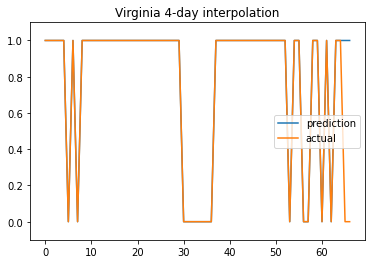

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Illinois
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.84432644 0.861742   0.83394355 0.8402466 ]
Illinois is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.9946 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 1.0000
Illinois loss: [0.9945701360702515, 0.5, 0.5, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

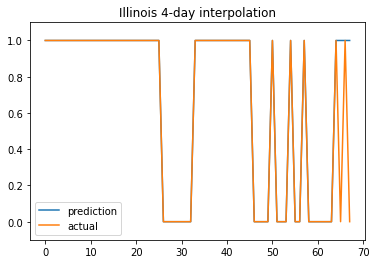

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Texas
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9417184  0.8765267  0.9919369  0.97921854]
Texas is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.2583 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Texas loss: [1.258324146270752, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


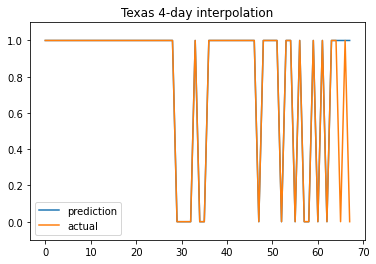

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Louisiana
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.6541058  0.6434768  0.84263116 0.8440939 ]
Louisiana is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.3015 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Louisiana loss: [0.3015182316303253, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

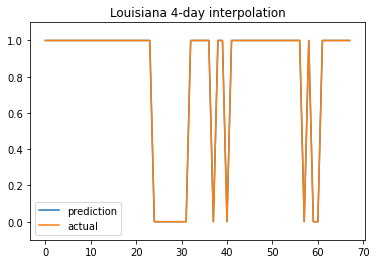

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for North Dakota
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.80176806 0.82942903 0.8060358  0.7725626 ]
North Dakota is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.9259 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 1.0000
North Dakota loss: [0.9258648157119751, 0.5, 0.5, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

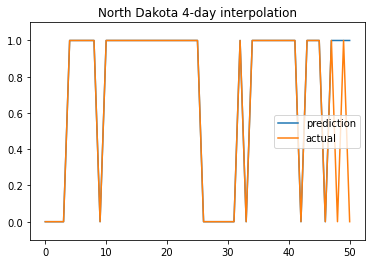

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for South Carolina
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8391525  0.7010458  0.2843767  0.07782709]
South Carolina is at lockdown level 2.0, predicted to decrease
region_prediction: [1. 1. 0. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.4983 - accuracy: 0.2500 - precision_15: 0.5000 - recall_15: 0.3333
South Carolina loss: [1.4983004331588745, 0.25, 0.5, 0.3333333432674408]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


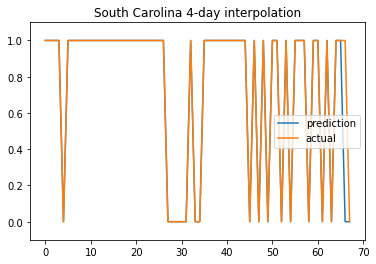

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Oregon
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.88226247 0.87465775 0.9959643  0.9973429 ]
Oregon is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 994us/step - loss: 0.5700 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Oregon loss: [0.5699810981750488, 0.75, 0.75, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


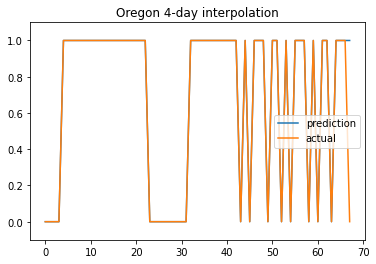

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Arkansas
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.6566985  0.66468453 0.7885824  0.74320513]
Arkansas is at lockdown level 3.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.6065 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Arkansas loss: [0.6064922213554382, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

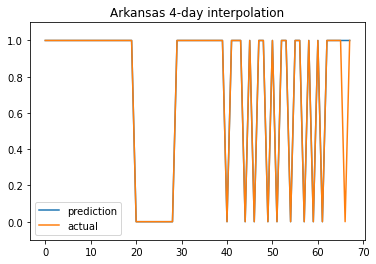

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Hawaii
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9279097  0.9327369  0.9495261  0.96766037]
Hawaii is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0573 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Hawaii loss: [0.05727984011173248, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

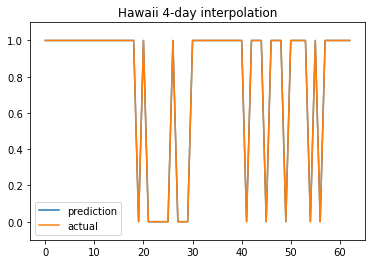

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Maryland
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.5577283  0.59656554 0.8049614  0.8052109 ]
Maryland is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.1905 - accuracy: 0.2500 - precision_15: 0.2500 - recall_15: 1.0000
Maryland loss: [1.190505027770996, 0.25, 0.25, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

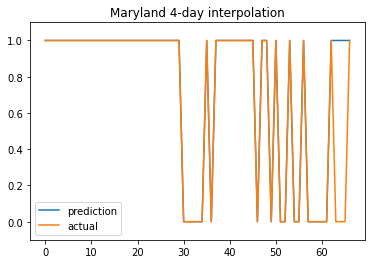

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Missouri
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.5781719  0.36597455 0.99819106 0.96867275]
Missouri is at lockdown level 2.0, predicted to increase
region_prediction: [1. 0. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 976us/step - loss: 2.9117 - accuracy: 0.0000e+00 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Missouri loss: [2.9116525650024414, 0.0, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

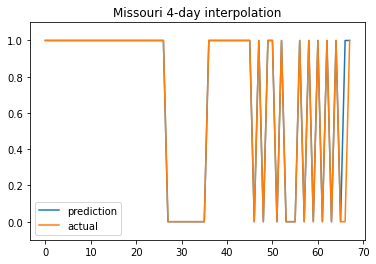

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Oklahoma
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.06847934 0.952438   0.99937916 0.98944515]
Oklahoma is at lockdown level 2.0, predicted to increase
region_prediction: [0. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.8787 - accuracy: 0.7500 - precision_15: 0.6667 - recall_15: 1.0000
Oklahoma loss: [1.8786969184875488, 0.75, 0.6666666865348816, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


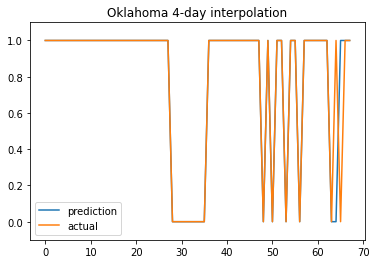

actual	prediction

[(array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for New Jersey
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9509893  0.9579322  0.97386473 0.9767039 ]
New Jersey is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
New Jersey loss: [0.03582135587930679, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

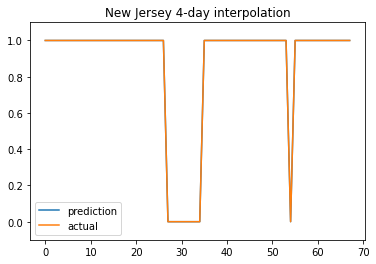

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for South Dakota
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.7160001  0.69368446 0.70763654 0.7166543 ]
South Dakota is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 950us/step - loss: 0.3447 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
South Dakota loss: [0.3446998596191406, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

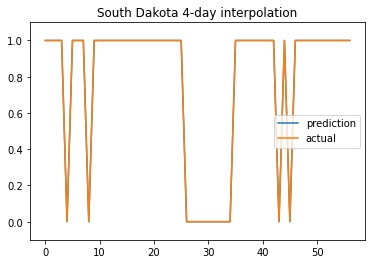

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Pennsylvania
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.850252   0.8547762  0.83975446 0.8420013 ]
Pennsylvania is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 955us/step - loss: 0.5805 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Pennsylvania loss: [0.5805399417877197, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


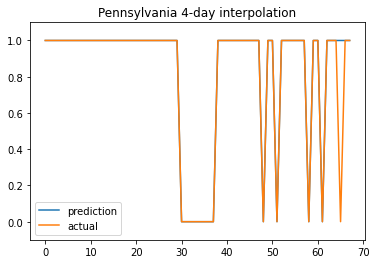

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Montana
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.12191217 0.07848053 0.09549265 0.04462507]
Montana is at lockdown level 2.0, predicted to decrease
region_prediction: [0. 0. 0. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.9111 - accuracy: 0.2500 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Montana loss: [1.9110877513885498, 0.25, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

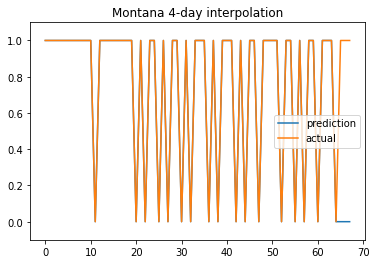

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Nebraska
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9262552 0.8866992 0.7794762 0.7202924]
Nebraska is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.1935 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Nebraska loss: [0.19352152943611145, 1.0, 1.0, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

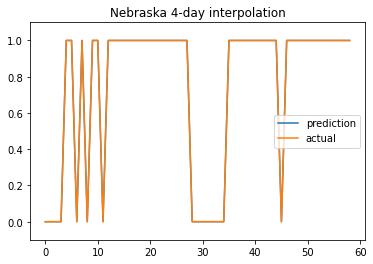

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Colorado
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9092322  0.88849914 0.9988341  0.9995957 ]
Colorado is at lockdown level 3.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 4.2141 - accuracy: 0.2500 - precision_15: 0.2500 - recall_15: 1.0000
Colorado loss: [4.214090824127197, 0.25, 0.25, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

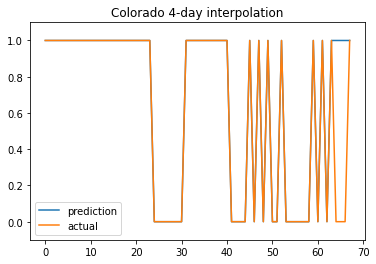

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Kansas
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.7945485  0.72505623 0.9807685  0.98621595]
Kansas is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 840us/step - loss: 0.3886 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Kansas loss: [0.3886171579360962, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


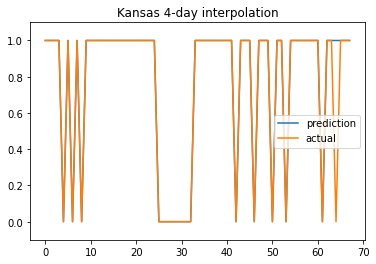

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Indiana
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.36966327 0.3250629  0.9087392  0.7204705 ]
Indiana is at lockdown level 3.0, predicted to increase
region_prediction: [0. 0. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 962us/step - loss: 1.1308 - accuracy: 0.5000 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Indiana loss: [1.1308295726776123, 0.5, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

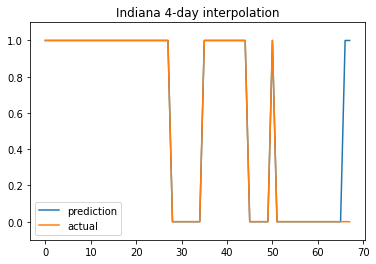

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Alabama
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.18075423 0.47891083 0.55195546 0.5897382 ]
Alabama is at lockdown level 3.0, predicted to increase
region_prediction: [0. 0. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 941us/step - loss: 0.9830 - accuracy: 0.2500 - precision_15: 0.5000 - recall_15: 0.3333
Alabama loss: [0.9830263257026672, 0.25, 0.5, 0.3333333432674408]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

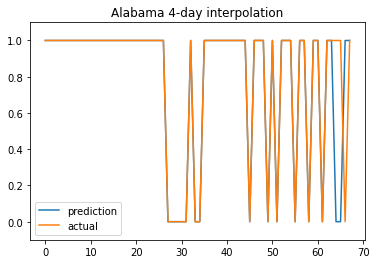

actual	prediction

[(array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for West Virginia
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.73094696 0.6662887  0.99967504 0.2504852 ]
West Virginia is at lockdown level 2.0, predicted to decrease
region_prediction: [1. 1. 1. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.7759 - accuracy: 0.5000 - precision_15: 0.6667 - recall_15: 0.6667
West Virginia loss: [0.7758898138999939, 0.5, 0.6666666865348816, 0.6666666865348816]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 

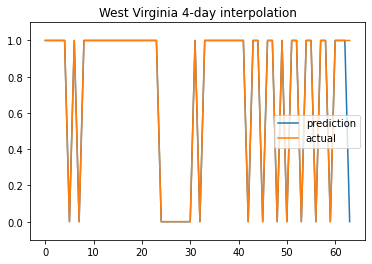

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Vermont
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9249884  0.92197967 0.996684   0.9978205 ]
Vermont is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0412 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Vermont loss: [0.041177406907081604, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

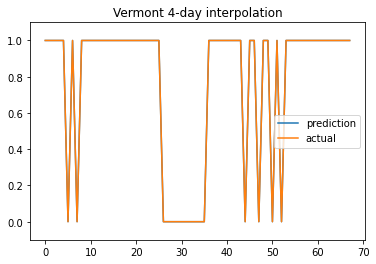

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Maine
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.29141924 0.5883316  0.28064215 0.32378066]
Maine is at lockdown level 3.0, predicted to decrease
region_prediction: [0. 1. 0. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 898us/step - loss: 0.9456 - accuracy: 0.2500 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Maine loss: [0.945610523223877, 0.25, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

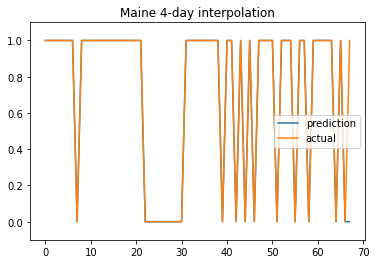

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Nevada
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.82866096 0.8194032  0.8150662  0.83147144]
Nevada is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Nevada loss: [0.5721191167831421, 0.75, 0.75, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

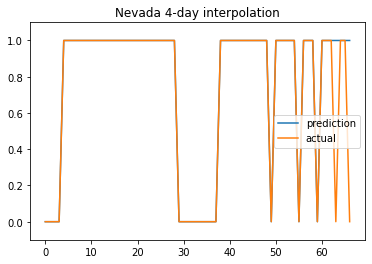

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Rhode Island
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.88747615 0.86902195 0.8306111  0.85650253]
Rhode Island is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.0698 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 1.0000
Rhode Island loss: [1.0697827339172363, 0.5, 0.5, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

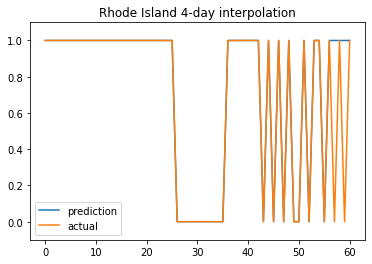

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Massachusetts
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.4936687  0.7133492  0.83934754 0.84688956]
Massachusetts is at lockdown level 5.0, predicted to increase
region_prediction: [0. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 981us/step - loss: 0.5678 - accuracy: 0.7500 - precision_15: 0.6667 - recall_15: 1.0000
Massachusetts loss: [0.5678424835205078, 0.75, 0.6666666865348816, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

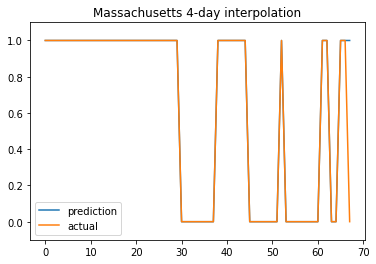

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Ohio
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.76151925 0.72323644 0.99181306 0.9890104 ]
Ohio is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 949us/step - loss: 1.8093 - accuracy: 0.2500 - precision_15: 0.2500 - recall_15: 1.0000
Ohio loss: [1.8092710971832275, 0.25, 0.25, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


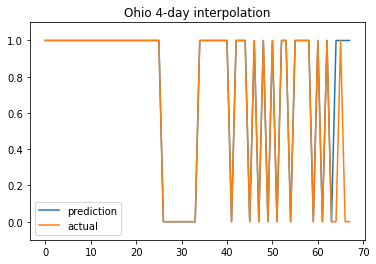

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Michigan
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8675209  0.8837029  0.85380155 0.8550912 ]
Michigan is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.1451 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Michigan loss: [0.14508841931819916, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

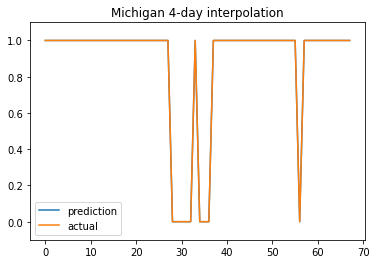

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for District of Columbia
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.7111398  0.73993725 0.9258859  0.93443   ]
District of Columbia is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.9789 - accuracy: 0.0000e+00 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
District of Columbia loss: [1.9788579940795898, 0.0, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.

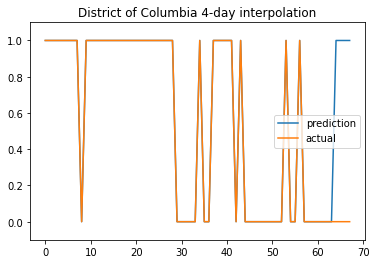

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Arizona
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.81329364 0.76052946 0.80856806 0.81760144]
Arizona is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.5125 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Arizona loss: [0.5124646425247192, 0.75, 0.75, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

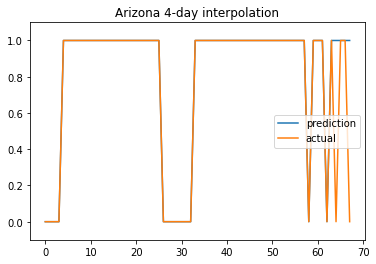

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for New York
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.97055435 0.97878563 0.9484004  0.95640016]
New York is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 964us/step - loss: 0.0372 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
New York loss: [0.03722197189927101, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

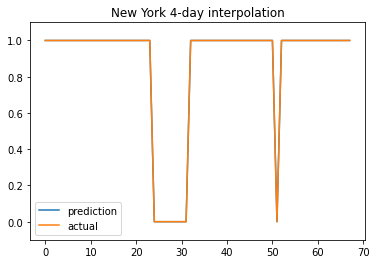

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Florida
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.80882156 0.740577   0.9953355  0.97578317]
Florida is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 913us/step - loss: 0.1354 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Florida loss: [0.13542324304580688, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

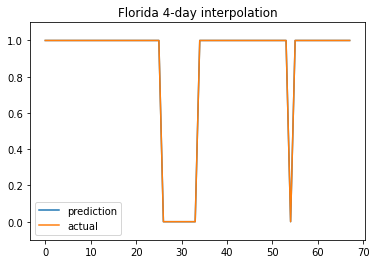

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Washington
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.81707627 0.80765307 0.9471391  0.96836823]
Washington is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 878us/step - loss: 0.1255 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Washington loss: [0.12552443146705627, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

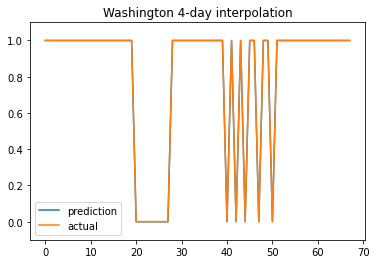

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Wyoming
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.0129636  0.15387304 0.08718503 0.02916263]
Wyoming is at lockdown level 3.0, predicted to decrease
region_prediction: [0. 0. 0. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 937us/step - loss: 2.6218 - accuracy: 0.2500 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Wyoming loss: [2.621821403503418, 0.25, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0

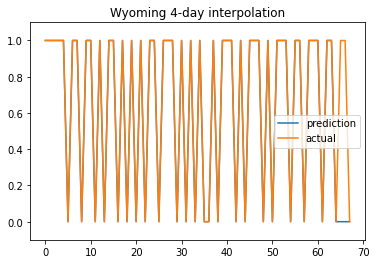

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Idaho
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.509362   0.00982091 0.11245695 0.15369637]
Idaho is at lockdown level 3.0, predicted to decrease
region_prediction: [1. 0. 0. 0.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 902us/step - loss: 1.1856 - accuracy: 0.5000 - precision_15: 1.0000 - recall_15: 0.3333
Idaho loss: [1.1856067180633545, 0.5, 1.0, 0.3333333432674408]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

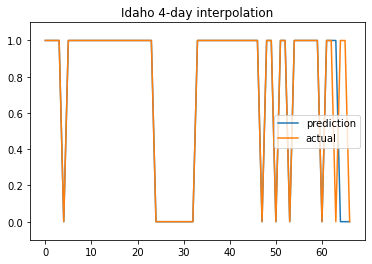

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32))]
predictions on validation dataset (10 days) for Wisconsin
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8373295 0.8304342 0.9946531 0.9977344]
Wisconsin is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 852us/step - loss: 1.6147 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Wisconsin loss: [1.6146600246429443, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

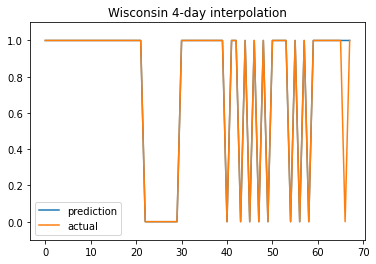

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for North Carolina
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.67866707 0.5967944  0.80099326 0.79755783]
North Carolina is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 895us/step - loss: 0.5249 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
North Carolina loss: [0.5248909592628479, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


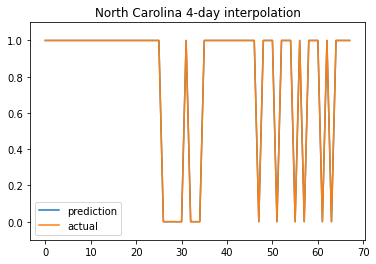

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Delaware
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.78881246 0.8487623  0.7302465  0.8707892 ]
Delaware is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.7919 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 1.0000
Delaware loss: [0.7918967604637146, 0.5, 0.5, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

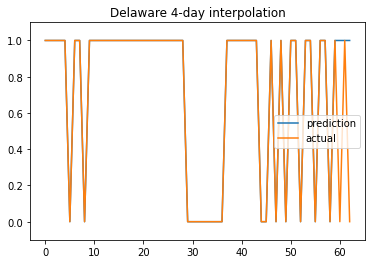

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Utah
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.633531   0.67484766 0.9969164  0.96270245]
Utah is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.2227 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Utah loss: [0.2227034717798233, 1.0, 1.0, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

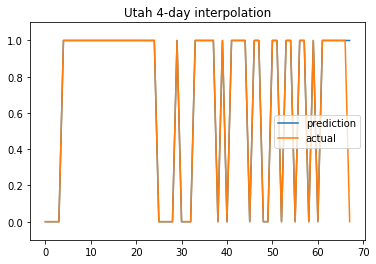

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Connecticut
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.5879448 0.6519495 0.9516814 0.9805834]
Connecticut is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.2570 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Connecticut loss: [0.25701072812080383, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

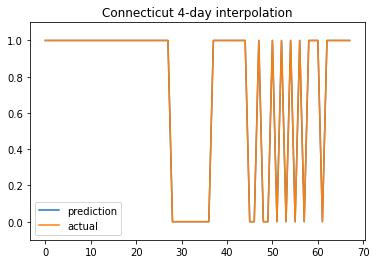

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Minnesota
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8774338 0.8751229 0.986515  0.9945932]
Minnesota is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0708 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Minnesota loss: [0.07078573107719421, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

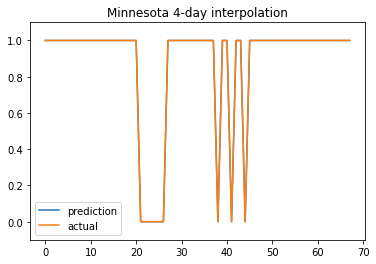

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for California
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.7442448  0.78810704 0.8209839  0.82826185]
California is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.5993 - accuracy: 0.0000e+00 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
California loss: [1.599318027496338, 0.0, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

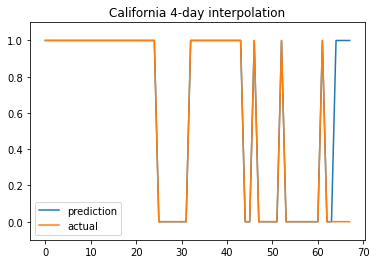

actual	prediction

[(array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Kentucky
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.4430622  0.59261346 0.6966261  0.65538615]
Kentucky is at lockdown level 4.0, predicted to increase
region_prediction: [0. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.8318 - accuracy: 0.2500 - precision_15: 0.3333 - recall_15: 0.5000
Kentucky loss: [0.8318394422531128, 0.25, 0.3333333432674408, 0.5]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


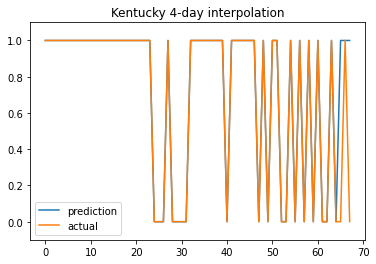

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Georgia
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.16658662 0.99843794 0.999979   0.99995327]
Georgia is at lockdown level 2.0, predicted to increase
region_prediction: [0. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0460 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Georgia loss: [0.04596414044499397, 1.0, 1.0, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


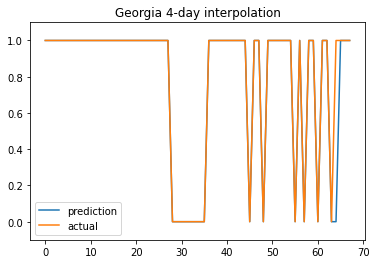

actual	prediction

[(array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for New Mexico
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8641899 0.857331  0.9877779 0.9938148]
New Mexico is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 890us/step - loss: 0.0796 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
New Mexico loss: [0.07959893345832825, 1.0, 1.0, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

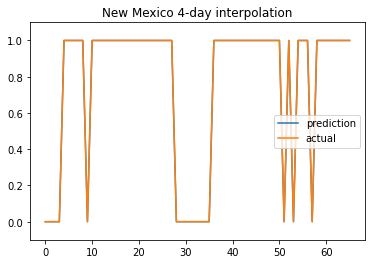

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Mississippi
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.15430619 0.17748213 0.12930506 0.52855337]
Mississippi is at lockdown level 3.0, predicted to increase
region_prediction: [0. 0. 0. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 950us/step - loss: 1.2154 - accuracy: 0.2500 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00
Mississippi loss: [1.21543288230896, 0.25, 0.0, 0.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

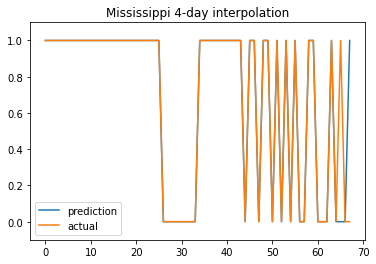

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for New Hampshire
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.75693744 0.7265706  0.99688524 0.9988457 ]
New Hampshire is at lockdown level 5.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 1.8767 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 1.0000
New Hampshire loss: [1.8766543865203857, 0.5, 0.5, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

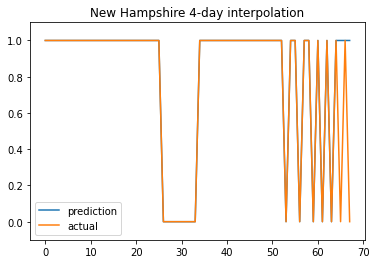

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Iowa
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.9333796  0.96183836 0.9498439  0.8704318 ]
Iowa is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0745 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000
Iowa loss: [0.07451892644166946, 1.0, 1.0, 1.0]
region_train_y: [[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1

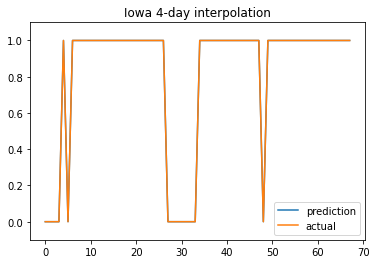

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Tennessee
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.8537103  0.8581067  0.96773404 0.8724425 ]
Tennessee is at lockdown level 2.0, predicted to increase
region_prediction: [1. 1. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.9703 - accuracy: 0.7500 - precision_15: 0.7500 - recall_15: 1.0000
Tennessee loss: [0.9703481197357178, 0.75, 0.75, 1.0]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

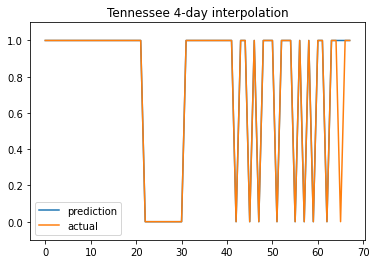

actual	prediction

[(array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
predictions on validation dataset (10 days) for Alaska
region_test_X.shape: (10, 31)
region_test_X_constant.shape: (10, 17)
region_test_y.shape: (10, 1)
region_test_X_seq.shape: (4, 5, 31)
region_test_X_const_seq.shape: (4, 5, 17)
pred: [0.34254166 0.2921484  0.981296   0.82513344]
Alaska is at lockdown level 2.0, predicted to increase
region_prediction: [0. 0. 1. 1.]
region_test_x_seq.shape: (4, 5, 31)  region_test_y_seq.shape: (4, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.7949 - accuracy: 0.5000 - precision_15: 0.5000 - recall_15: 0.5000
Alaska loss: [0.7948740720748901, 0.5, 0.5, 0.5]
region_train_y: [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.

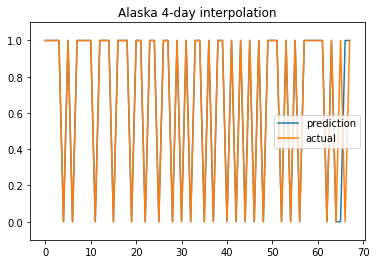

actual	prediction

[(array([0.], dtype=float32), array([0.], dtype=float32)),
 (array([1.], dtype=float32), array([0.], dtype=float32)),
 (array([0.], dtype=float32), array([1.], dtype=float32)),
 (array([1.], dtype=float32), array([1.], dtype=float32))]
{0: {0: [], 1: []},
 1: {0: [], 1: []},
 2: {0: ['South Carolina', 'Montana', 'West Virginia'],
     1: ['Texas',
         'North Dakota',
         'Missouri',
         'Oklahoma',
         'South Dakota',
         'Nebraska',
         'Florida',
         'Utah',
         'Georgia',
         'Iowa',
         'Tennessee',
         'Alaska']},
 3: {0: ['Maine', 'Wyoming', 'Idaho'],
     1: ['Arkansas', 'Colorado', 'Indiana', 'Alabama', 'Mississippi']},
 4: {0: [], 1: ['Kentucky']},
 5: {0: [],
     1: ['Virginia',
         'Illinois',
         'Louisiana',
         'Oregon',
         'Hawaii',
         'Maryland',
         'New Jersey',
         'Pennsylvania',
         'Kansas',
         'Vermont',
         'Nevada',
         'Rhode Isl

In [50]:
t = build_national_TCNmodel()

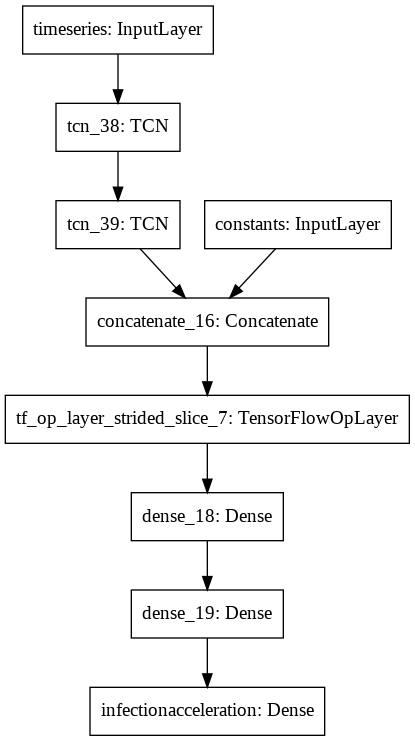

In [52]:
tensorflow.keras.utils.plot_model(t.m)
#model_img = plt.imread("./model.png")
#plt.imshow(model_img)
#plt.show()